In [13]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_classif

In [14]:
import warnings
warnings.simplefilter("ignore")

# LOAD DATA

In [15]:
neutral = ["N"]*15
happy = ["H"] *15
anger = ["A"] *15
L = neutral+happy+anger
def load_noise_data(FILIP_PATH,noise_level,no_of_sentences,which):
    data = [i for i in range(no_of_sentences)]
    for i in range(1, no_of_sentences+1):
        
        file_name = "sentence"+str(i)+L[i-1]+"_"+which+"_"+noise_level+".wav"
        y, sr = librosa.load(FILIP_PATH+file_name, sr=None)
        data[i-1] = y
    return data

In [16]:
DATA_PATH = "BazaNoise/"
FILIP_PATH = DATA_PATH + "sentencesFilipNoise/"
SEB_PATH = DATA_PATH + "sentencesSebastianNoise/"
MARCIN_PATH = DATA_PATH + "sentencesMarcinNoise/"
PROF_PATH = DATA_PATH + "sentencesProfessorNoise/"
no_of_sentences = 45
Fs = 48000


## Functions to get mfcc features

In [17]:
def get_mfcc_mean_features(data,no_of_sentences, mfcc_features_no):
    mfcc = [i for i in range(no_of_sentences)]
    mfcc_delta = [i for i in range(no_of_sentences)]
    mfcc_delta2 = [i for i in range(no_of_sentences)]

    for i, word in enumerate(data):
        mfcc[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
        mfcc_delta[i] = librosa.feature.delta(word)
        mfcc_delta2[i] =  librosa.feature.delta(word, order=2)

    mfcc_mean = np.zeros((no_of_sentences,mfcc_features_no))
    for i in range(no_of_sentences):
        mfcc_mean[i,0:mfcc_features_no] = np.mean(mfcc[i],axis=1)
    
    return mfcc_mean

def get_mfcc_features(data,mfcc_features_no):
    mfcc = [i for i in range(no_of_sentences)]
    mfcc_delta = [i for i in range(no_of_sentences)]
    mfcc_delta2 = [i for i in range(no_of_sentences)]

    for i, word in enumerate(data):
        mfcc[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
        mfcc_delta[i] = librosa.feature.delta(word)
        mfcc_delta2[i] =  librosa.feature.delta(word, order=2)
        
    return mfcc

# Functions to get spectal features

In [18]:
def get_spectral_mean_features(data, no_of_sentences,spectral_features_no = 4):
    spectral_features = [i for i in range(no_of_sentences)]
    sr = 48000
    for i, word in enumerate(data):
        spectral_features_vector = np.zeros(4)
        spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
        spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
        spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
        spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
        spectral_features[i] = spectral_features_vector
    return spectral_features

## Functions to get zero crossing

In [19]:
def get_zero_crossing_features(data, no_of_sentences) :
    zcr_mean = np.zeros((no_of_sentences, 1))
    for i in range(no_of_sentences):
        zcr_mean[i, 0] = np.mean(data[i])
    return zcr_mean

## Functions to get chroma features

In [20]:
def get_mean_chroma_features(data, chroma_types):

    chroma_stft = []
    chroma_cqt = []
    chroma_cens = []
    chroma_vqt = []

    sr = 48000

    for audio in data:
        word_stft = chroma_types[list(chroma_types.keys())[0]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[0]]["params"])
        word_cqt = chroma_types[list(chroma_types.keys())[1]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[1]]["params"])
        word_cens = chroma_types[list(chroma_types.keys())[2]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[2]]["params"])
        word_vqt = chroma_types[list(chroma_types.keys())[3]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[3]]["params"])


        chroma_stft.append(word_stft.mean(axis=1).flatten())
        chroma_cqt.append(word_cqt.mean(axis=1).flatten())
        chroma_cens.append(word_cens.mean(axis=1).flatten())
        chroma_vqt.append(word_vqt.mean(axis=1).flatten())

    return chroma_stft, chroma_cqt, chroma_cens, chroma_vqt

chroma_types ={
    "stft": {
        "func": librosa.feature.chroma_stft,
        "params": {},
    },
    "cqt": {
        "func": librosa.feature.chroma_cqt,
        "params": {},
    },
    "cens": {
        "func": librosa.feature.chroma_cens,
        "params": {},
    },
    "vqt": {
        "func": librosa.feature.chroma_vqt,
        "params": {"intervals": "equal"},
    }
}

# Functions to get classifier results and show confusion matrix

In [21]:
def get_clf_results(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred), y_pred

def show_conf_matirx(y_test, y_pred,clf,feature ):
    cm = confusion_matrix(y_test, y_pred)
    ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]

    sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
    plt.ylabel('Prediction',fontsize=12)
    plt.xlabel('Actual',fontsize=12)
    plt.title('Confusion Matrix - ' + feature +" - "+type(clf).__name__,fontsize=16)
    plt.show()

## Classifiers

# Getting full features

In [22]:
def get_feature_vector_mfcc(words_filip,words_seb,words_marcin, words_prof, no_of_sentences, mfcc_features_no):
    mfcc_filip_mean = get_mfcc_mean_features(words_filip,no_of_sentences,mfcc_features_no)
    mfcc_seb_mean = get_mfcc_mean_features(words_seb,no_of_sentences,mfcc_features_no)
    mfcc_marcin_mean = get_mfcc_mean_features(words_marcin,no_of_sentences,mfcc_features_no)
    mfcc_prof_mean = get_mfcc_mean_features(words_prof,no_of_sentences,mfcc_features_no)

    feature_vector_mfcc = np.concatenate((mfcc_filip_mean, mfcc_seb_mean,mfcc_marcin_mean,mfcc_prof_mean))

    return feature_vector_mfcc

def get_feature_vector_spectral(words_filip,words_seb,words_marcin, words_prof, no_of_sentences,spectral_features_no):
    spectral_features_filip = get_spectral_mean_features(words_filip, no_of_sentences,spectral_features_no)
    spectral_features_seb = get_spectral_mean_features(words_seb, no_of_sentences,spectral_features_no)
    spectral_features_marcin = get_spectral_mean_features(words_marcin, no_of_sentences,spectral_features_no)
    spectral_features_prof = get_spectral_mean_features(words_prof, no_of_sentences,spectral_features_no)

    feature_vector_spectral = np.concatenate((spectral_features_filip, spectral_features_seb,spectral_features_marcin,spectral_features_prof))

    return feature_vector_spectral

def get_feature_vector_zeros(words_filip,words_seb,words_marcin, words_prof, no_of_sentences):
    zcr_filip  = get_zero_crossing_features(words_filip, no_of_sentences)
    zcr_seb    = get_zero_crossing_features(words_seb, no_of_sentences)
    zcr_marcin = get_zero_crossing_features(words_marcin, no_of_sentences)
    zcr_prof   = get_zero_crossing_features(words_prof, no_of_sentences)

    feature_vector_zeros = np.concatenate((zcr_filip, zcr_seb,zcr_marcin,zcr_prof))

    return feature_vector_zeros

def get_feature_vector_chroma(words_filip,words_seb,words_marcin, words_prof,chroma_types):
    chroma_filip_stft_mean, chroma_filip_cqt_mean, chroma_filip_cens_mean, chroma_filip_vqt_mean = get_mean_chroma_features(words_filip, chroma_types)
    chroma_seb_stft_mean, chroma_seb_cqt_mean, chroma_seb_cens_mean, chroma_seb_vqt_mean = get_mean_chroma_features(words_seb, chroma_types)
    chroma_marcin_stft_mean, chroma_marcin_cqt_mean, chroma_marcin_cens_mean, chroma_marcin_vqt_mean = get_mean_chroma_features(words_marcin, chroma_types)
    chroma_prof_stft_mean, chroma_prof_cqt_mean, chroma_prof_cens_mean, chroma_prof_vqt_mean = get_mean_chroma_features(words_prof, chroma_types)

    chroma_filip = np.concatenate((np.array(chroma_filip_stft_mean),np.array(chroma_filip_cqt_mean),np.array(chroma_filip_cens_mean),np.array(chroma_filip_vqt_mean)),axis=1)
    chroma_seb = np.concatenate((np.array(chroma_seb_stft_mean),np.array(chroma_seb_cqt_mean),np.array(chroma_seb_cens_mean),np.array(chroma_seb_vqt_mean)),axis=1)
    chroma_marcin = np.concatenate((np.array(chroma_marcin_stft_mean),np.array(chroma_marcin_cqt_mean),np.array(chroma_marcin_cens_mean),np.array(chroma_marcin_vqt_mean)),axis=1)
    chroma_prof = np.concatenate((np.array(chroma_prof_stft_mean),np.array(chroma_prof_cqt_mean),np.array(chroma_prof_cens_mean),np.array(chroma_prof_vqt_mean)),axis=1)

    feature_vector_chroma = np.concatenate((chroma_filip, chroma_seb,chroma_marcin,chroma_prof))

    return feature_vector_chroma


In [43]:
svm = SVC(kernel='rbf', C=1.0, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100,20), activation='relu', solver='adam', 
                         max_iter=3000, random_state=42)


def get_results_per_feature(feature_vector,feature_name):
    labels = L * 4
    X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=42)

    acc_score_svm, class_report_svm, y_pred_svm = get_clf_results(svm, X_train, X_test, y_train, y_test)
    acc_score_rbf, class_report_rbf, y_pred_rbf= get_clf_results(rf_clf, X_train, X_test, y_train, y_test)
    acc_score_mlp, class_report_mlp, y_pred_mlp = get_clf_results(mlp_clf, X_train, X_test, y_train, y_test)

    print(acc_score_svm, class_report_svm)
    print(acc_score_rbf, class_report_rbf)
    print(acc_score_mlp, class_report_mlp)

    show_conf_matirx(y_test, y_pred_svm,svm,feature_name)
    show_conf_matirx(y_test, y_pred_rbf,rf_clf,feature_name)
    show_conf_matirx(y_test, y_pred_mlp,mlp_clf,feature_name)
    

# Noise - 10%

In [ ]:
noise_level = "N10"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_sentences, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_sentences, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_sentences, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_sentences, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_sentences)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)


(180, 13)
(180,)
0.3333333333333333               precision    recall  f1-score   support

           A       0.31      1.00      0.47        27
           H       0.00      0.00      0.00        33
           N       1.00      0.10      0.18        30

    accuracy                           0.33        90
   macro avg       0.44      0.37      0.22        90
weighted avg       0.43      0.33      0.20        90

0.7444444444444445               precision    recall  f1-score   support

           A       0.64      0.85      0.73        27
           H       0.89      0.48      0.63        33
           N       0.78      0.93      0.85        30

    accuracy                           0.74        90
   macro avg       0.77      0.76      0.74        90
weighted avg       0.78      0.74      0.73        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N    

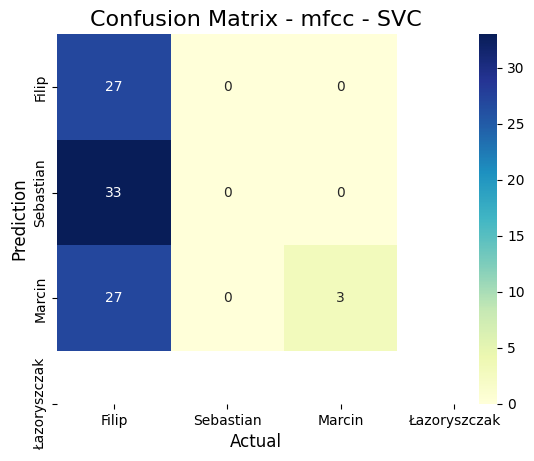

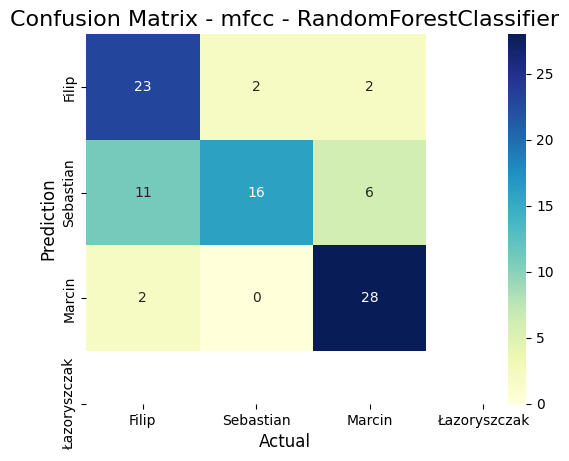

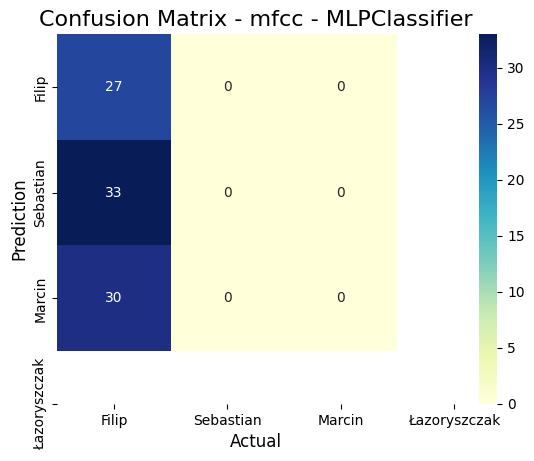

In [45]:
print(feature_vector_mfcc.shape)
get_results_per_feature(feature_vector_mfcc,"mfcc")
# get_results_per_feature(feature_vector_spectral,"Spectral")
# get_results_per_feature(feature_vector_zeros,"Zero Crossing")
# get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 20%

In [46]:
noise_level = "N20"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_sentences, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_sentences, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_sentences, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_sentences, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_sentences)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.7222222222222222               precision    recall  f1-score   support

           A       0.63      0.81      0.71        27
           H       0.84      0.48      0.62        33
           N       0.75      0.90      0.82        30

    accuracy                           0.72        90
   macro avg       0.74      0.73      0.71        90
weighted avg       0.75      0.72      0.71        90

0.6777777777777778               precision    recall  f1-score   support

           A       0.54      0.70      0.61        27
           H       0.70      0.42      0.53        33
           N       0.80   

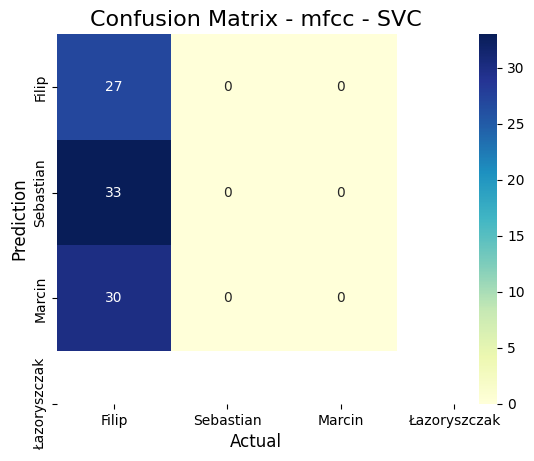

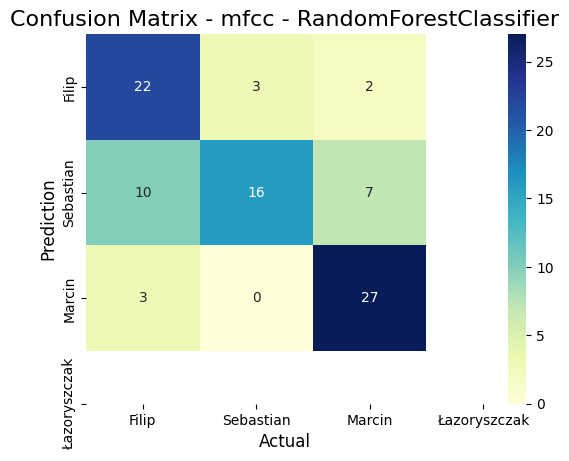

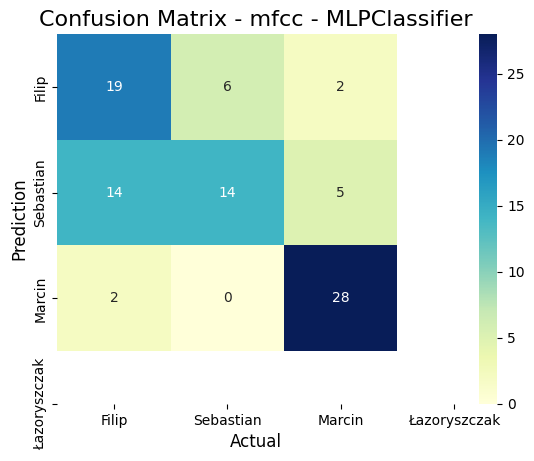

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.4666666666666667               precision    recall  f1-score   support

           A       0.39      0.52      0.44        27
           H       0.42      0.15      0.22        33
           N       0.55      0.77      0.64        30

    accuracy                           0.47        90
   macro avg       0.45      0.48      0.44        90
weighted avg       0.45      0.47      0.43        90

0.3111111111111111               precision    recall  f1-score   support

           A       0.30      0.93      0.45        27
           H       0.00      0.00      0.00        33
           N       0.43   

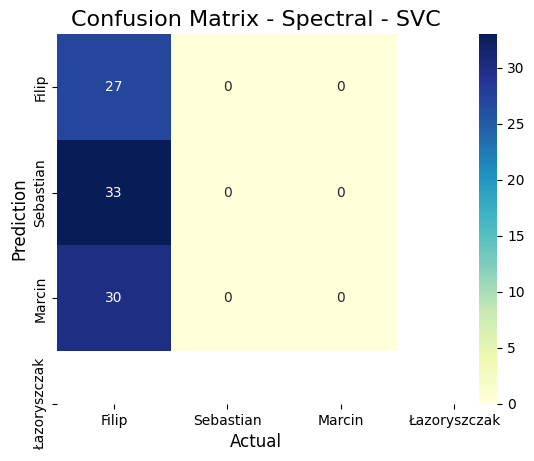

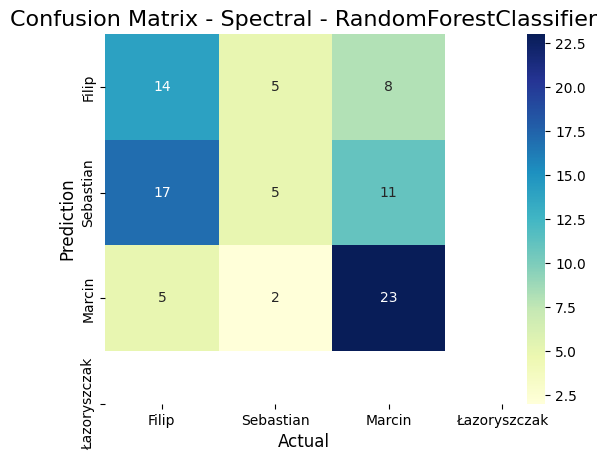

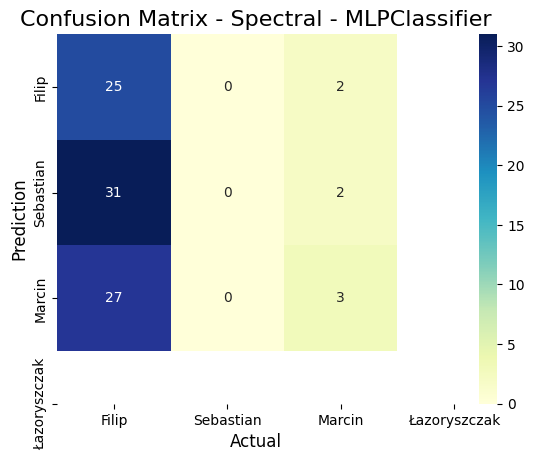

(180,)
0.34444444444444444               precision    recall  f1-score   support

           A       0.31      0.41      0.35        27
           H       0.43      0.18      0.26        33
           N       0.35      0.47      0.40        30

    accuracy                           0.34        90
   macro avg       0.36      0.35      0.33        90
weighted avg       0.37      0.34      0.33        90

0.26666666666666666               precision    recall  f1-score   support

           A       0.28      0.41      0.33        27
           H       0.36      0.15      0.21        33
           N       0.22      0.27      0.24        30

    accuracy                           0.27        90
   macro avg       0.28      0.28      0.26        90
weighted avg       0.29      0.27      0.26        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00 

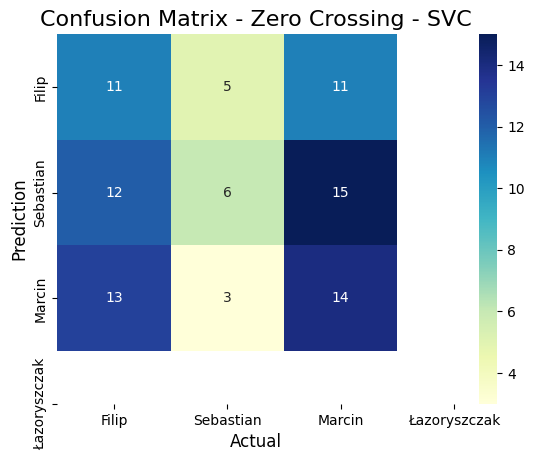

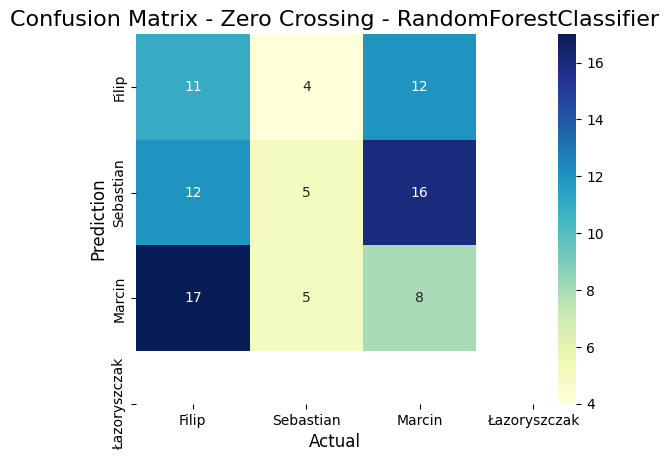

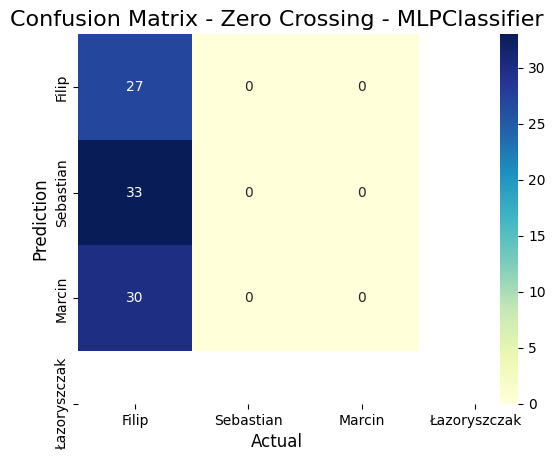

(180,)
0.5333333333333333               precision    recall  f1-score   support

           A       0.52      0.59      0.55        27
           H       0.47      0.27      0.35        33
           N       0.57      0.77      0.66        30

    accuracy                           0.53        90
   macro avg       0.52      0.54      0.52        90
weighted avg       0.52      0.53      0.51        90

0.5888888888888889               precision    recall  f1-score   support

           A       0.48      0.52      0.50        27
           H       0.60      0.36      0.45        33
           N       0.66      0.90      0.76        30

    accuracy                           0.59        90
   macro avg       0.58      0.59      0.57        90
weighted avg       0.58      0.59      0.57        90

0.6888888888888889               precision    recall  f1-score   support

           A       0.60      0.78      0.68        27
           H       0.65      0.45      0.54        33
           

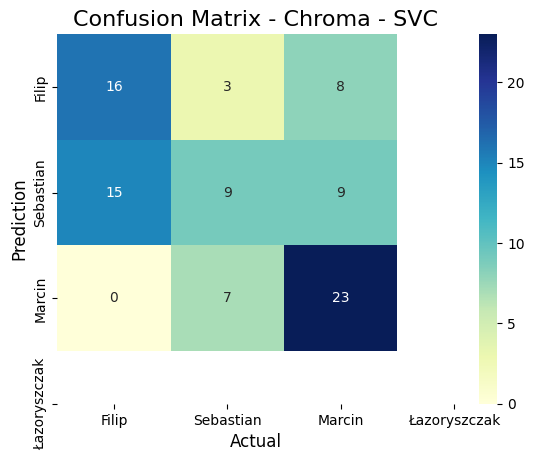

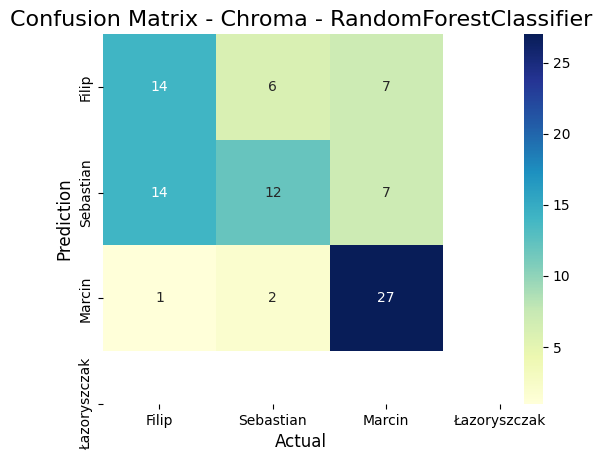

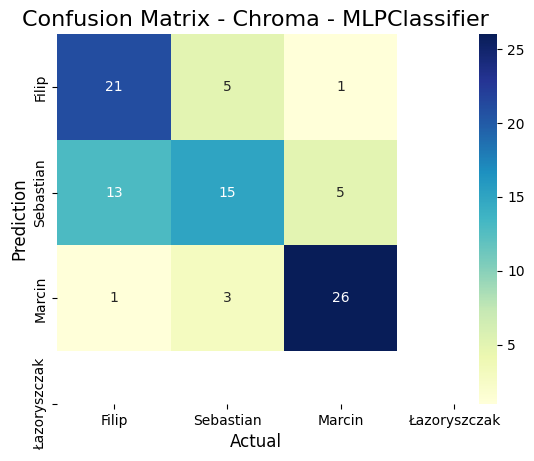

In [47]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 30 %

In [48]:
noise_level = "N30"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_sentences, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_sentences, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_sentences, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_sentences, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_sentences)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.7               precision    recall  f1-score   support

           A       0.61      0.70      0.66        27
           H       0.75      0.45      0.57        33
           N       0.74      0.97      0.84        30

    accuracy                           0.70        90
   macro avg       0.70      0.71      0.69        90
weighted avg       0.71      0.70      0.68        90

0.6888888888888889               precision    recall  f1-score   support

           A       0.57      0.74      0.65        27
           H       0.75      0.45      0.57        33
           N       0.77      0.90      0.

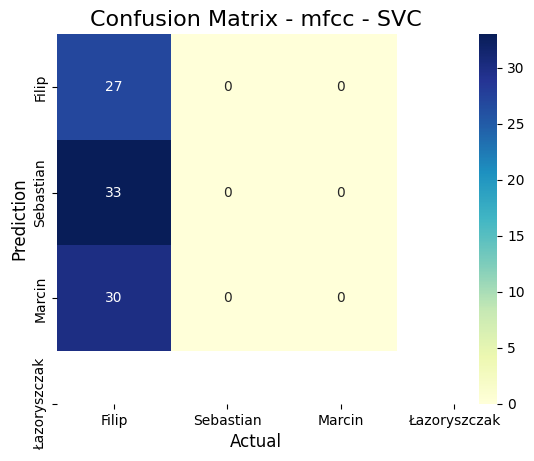

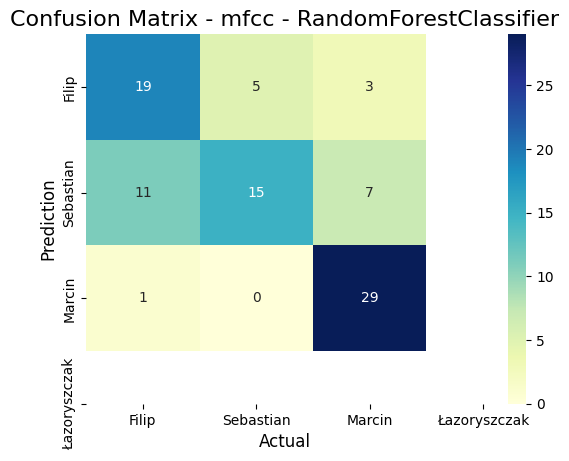

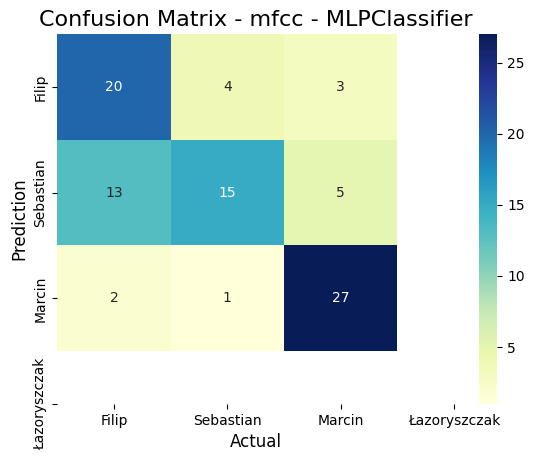

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.4666666666666667               precision    recall  f1-score   support

           A       0.41      0.56      0.47        27
           H       0.33      0.15      0.21        33
           N       0.58      0.73      0.65        30

    accuracy                           0.47        90
   macro avg       0.44      0.48      0.44        90
weighted avg       0.44      0.47      0.43        90

0.5222222222222223               precision    recall  f1-score   support

           A       0.00      0.00      0.00        27
           H       0.47      0.58      0.52        33
           N       0.56   

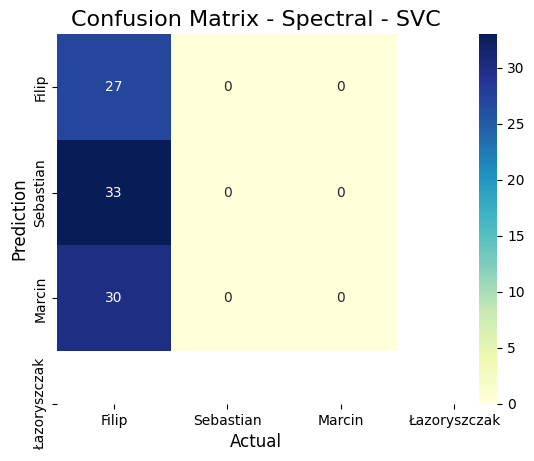

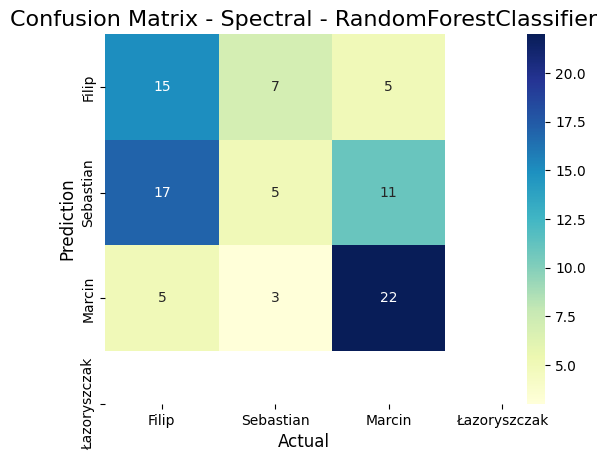

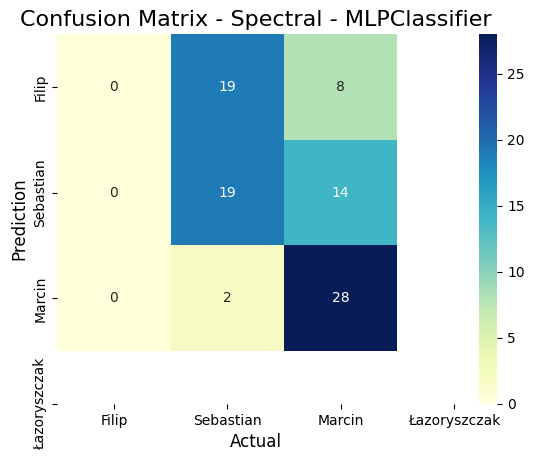

(180,)
0.34444444444444444               precision    recall  f1-score   support

           A       0.38      0.33      0.35        27
           H       0.00      0.00      0.00        33
           N       0.34      0.73      0.46        30

    accuracy                           0.34        90
   macro avg       0.24      0.36      0.27        90
weighted avg       0.23      0.34      0.26        90

0.4               precision    recall  f1-score   support

           A       0.39      0.56      0.46        27
           H       0.44      0.33      0.38        33
           N       0.37      0.33      0.35        30

    accuracy                           0.40        90
   macro avg       0.40      0.41      0.40        90
weighted avg       0.40      0.40      0.39        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0

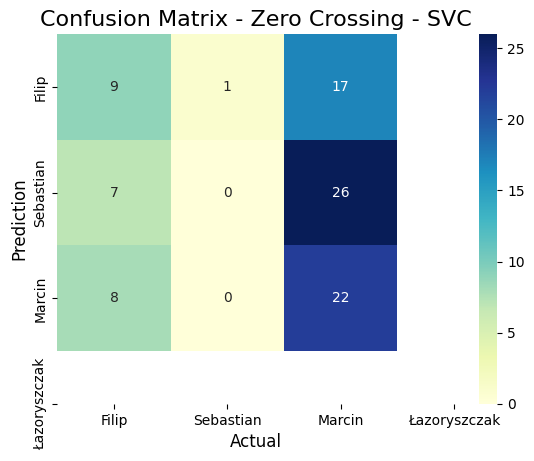

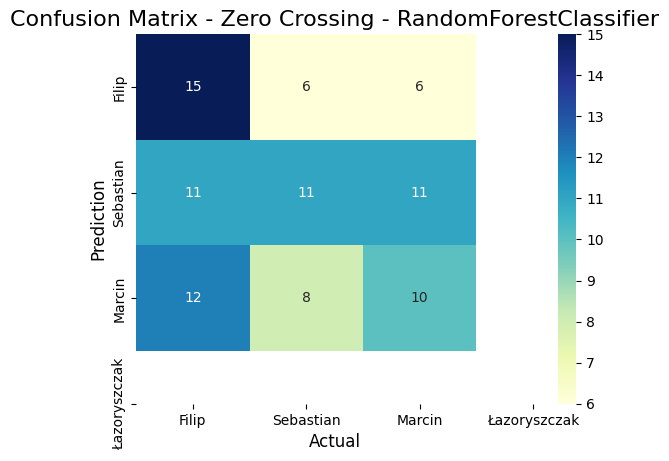

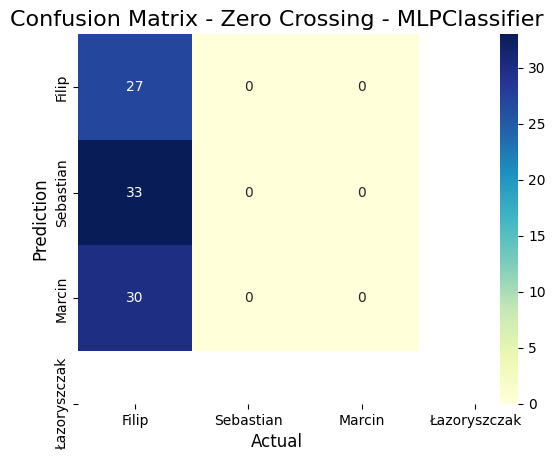

(180,)
0.5555555555555556               precision    recall  f1-score   support

           A       0.55      0.67      0.60        27
           H       0.58      0.21      0.31        33
           N       0.56      0.83      0.67        30

    accuracy                           0.56        90
   macro avg       0.56      0.57      0.53        90
weighted avg       0.56      0.56      0.52        90

0.6222222222222222               precision    recall  f1-score   support

           A       0.51      0.67      0.58        27
           H       0.65      0.33      0.44        33
           N       0.71      0.90      0.79        30

    accuracy                           0.62        90
   macro avg       0.62      0.63      0.60        90
weighted avg       0.63      0.62      0.60        90

0.6222222222222222               precision    recall  f1-score   support

           A       0.52      0.63      0.57        27
           H       0.60      0.36      0.45        33
           

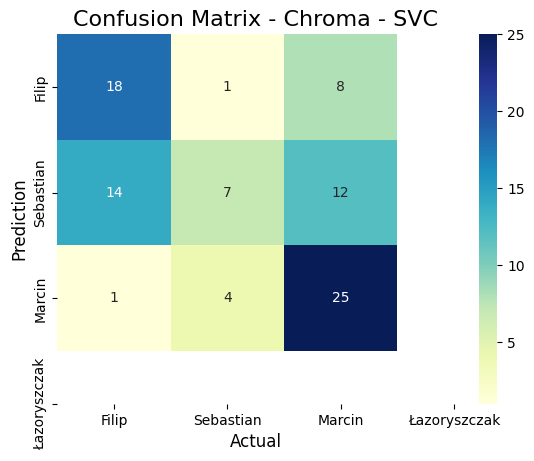

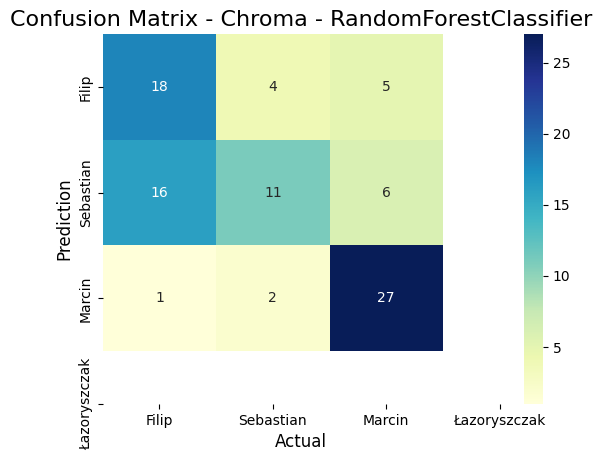

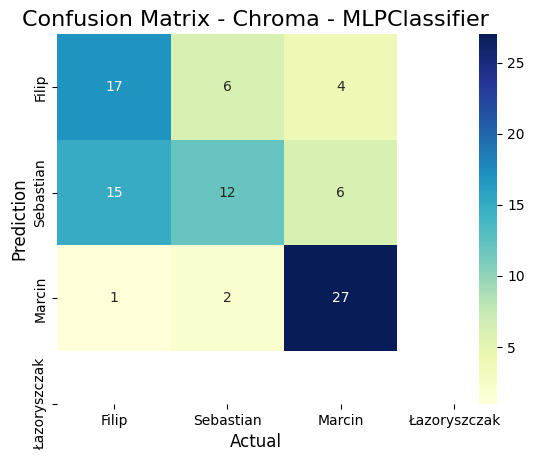

In [49]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 40%

In [50]:
noise_level = "N40"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_sentences, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_sentences, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_sentences, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_sentences, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_sentences)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.6666666666666666               precision    recall  f1-score   support

           A       0.57      0.74      0.65        27
           H       0.75      0.45      0.57        33
           N       0.71      0.83      0.77        30

    accuracy                           0.67        90
   macro avg       0.68      0.68      0.66        90
weighted avg       0.68      0.67      0.66        90

0.6               precision    recall  f1-score   support

           A       0.47      0.81      0.59        27
           H       0.70      0.21      0.33        33
           N       0.76      0.83      0.

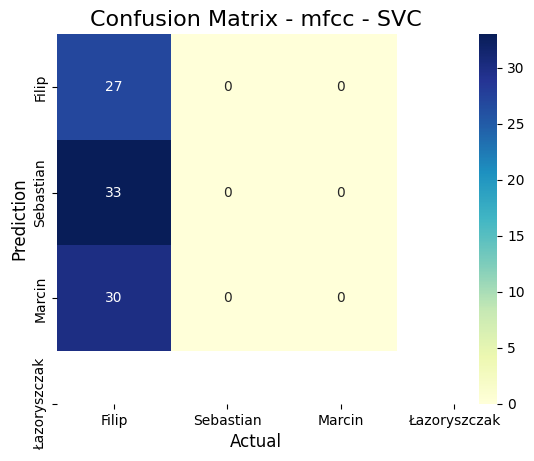

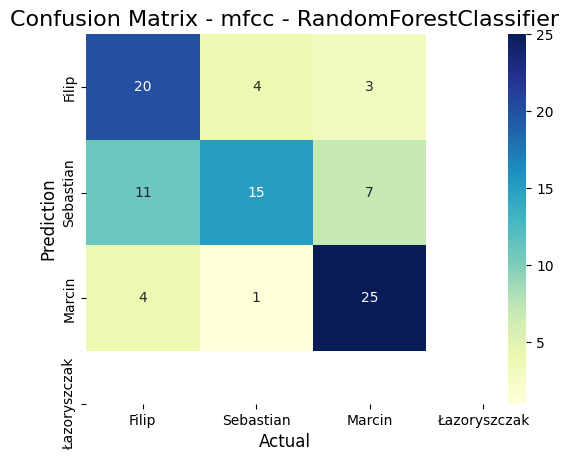

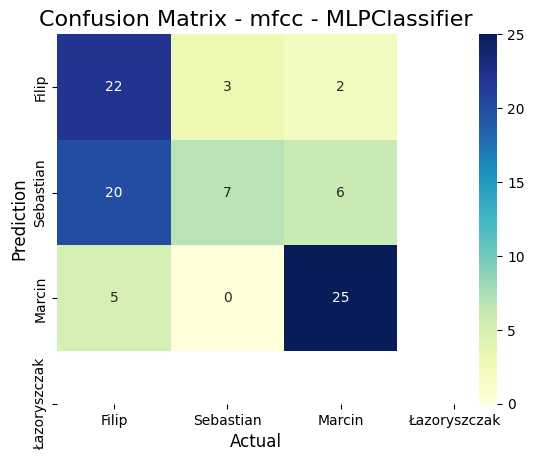

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.6222222222222222               precision    recall  f1-score   support

           A       0.52      0.56      0.54        27
           H       0.71      0.45      0.56        33
           N       0.65      0.87      0.74        30

    accuracy                           0.62        90
   macro avg       0.63      0.63      0.61        90
weighted avg       0.63      0.62      0.61        90

0.5111111111111111               precision    recall  f1-score   support

           A       0.42      0.81      0.55        27
           H       0.83      0.15      0.26        33
           N       0.61   

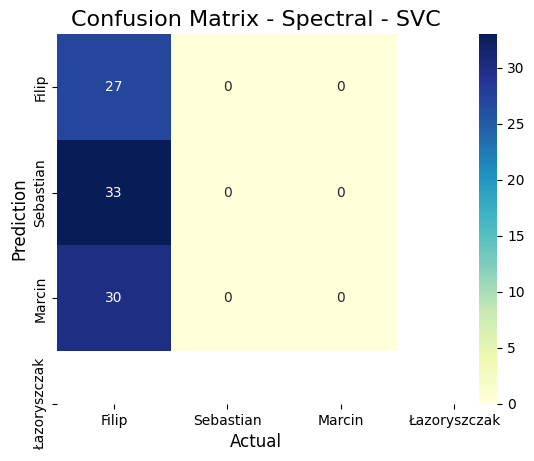

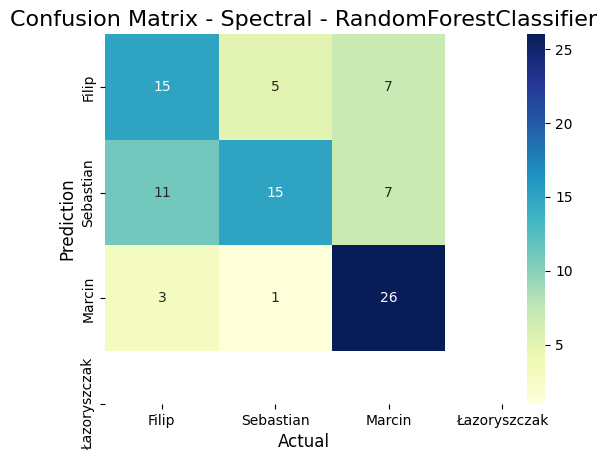

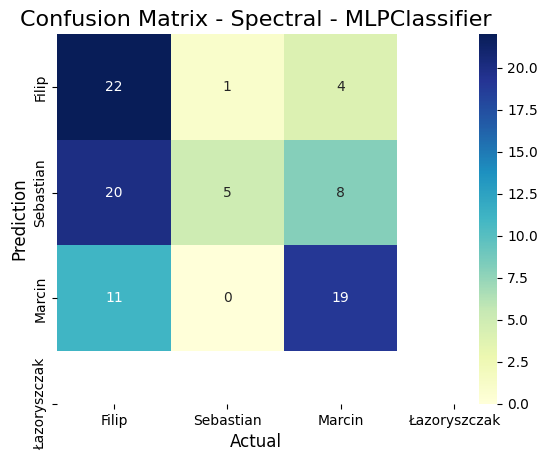

(180,)
0.35555555555555557               precision    recall  f1-score   support

           A       0.41      0.33      0.37        27
           H       0.00      0.00      0.00        33
           N       0.34      0.77      0.47        30

    accuracy                           0.36        90
   macro avg       0.25      0.37      0.28        90
weighted avg       0.24      0.36      0.27        90

0.34444444444444444               precision    recall  f1-score   support

           A       0.30      0.44      0.36        27
           H       0.36      0.27      0.31        33
           N       0.40      0.33      0.36        30

    accuracy                           0.34        90
   macro avg       0.35      0.35      0.34        90
weighted avg       0.36      0.34      0.34        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00 

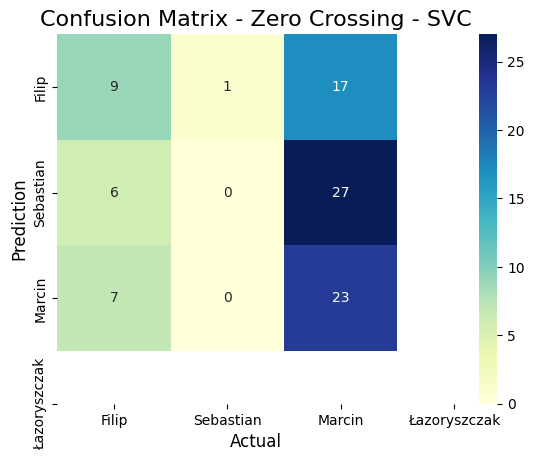

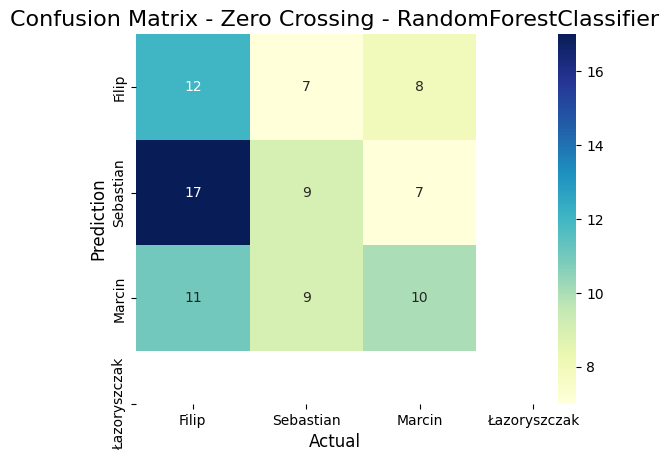

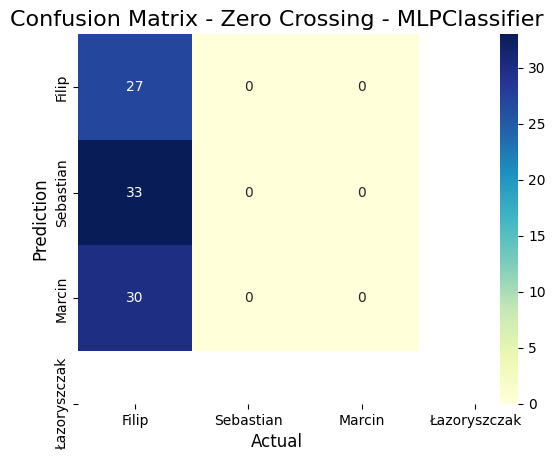

(180,)
0.5444444444444444               precision    recall  f1-score   support

           A       0.46      0.67      0.55        27
           H       0.60      0.18      0.28        33
           N       0.61      0.83      0.70        30

    accuracy                           0.54        90
   macro avg       0.56      0.56      0.51        90
weighted avg       0.56      0.54      0.50        90

0.7111111111111111               precision    recall  f1-score   support

           A       0.56      0.81      0.67        27
           H       0.78      0.42      0.55        33
           N       0.85      0.93      0.89        30

    accuracy                           0.71        90
   macro avg       0.73      0.72      0.70        90
weighted avg       0.74      0.71      0.70        90

0.6333333333333333               precision    recall  f1-score   support

           A       0.53      0.74      0.62        27
           H       0.57      0.36      0.44        33
           

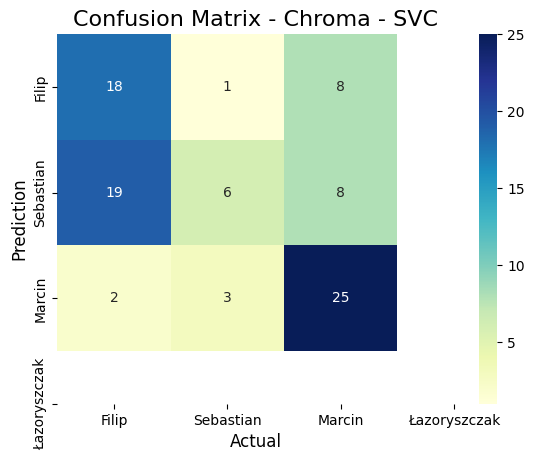

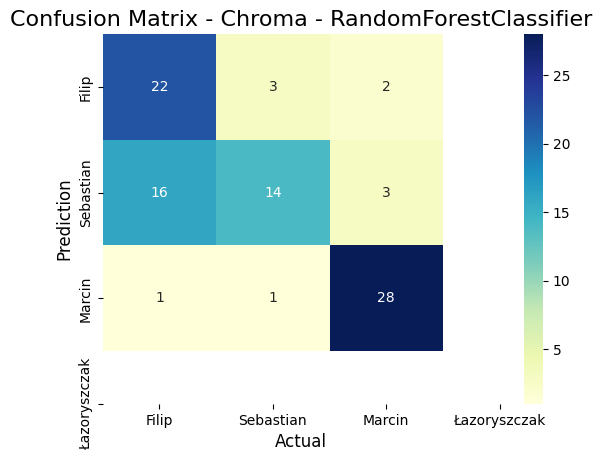

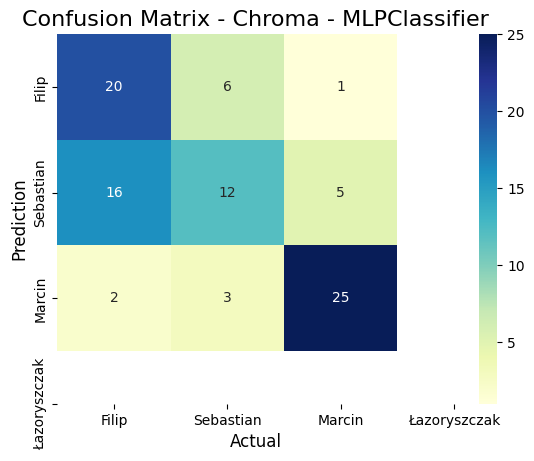

In [51]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 50%

In [52]:
noise_level = "N50"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_sentences, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_sentences, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_sentences, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_sentences, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_sentences)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.6444444444444445               precision    recall  f1-score   support

           A       0.51      0.67      0.58        27
           H       0.74      0.42      0.54        33
           N       0.72      0.87      0.79        30

    accuracy                           0.64        90
   macro avg       0.66      0.65      0.64        90
weighted avg       0.67      0.64      0.63        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.

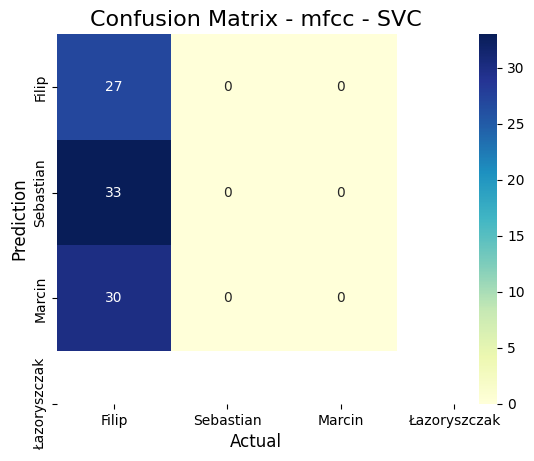

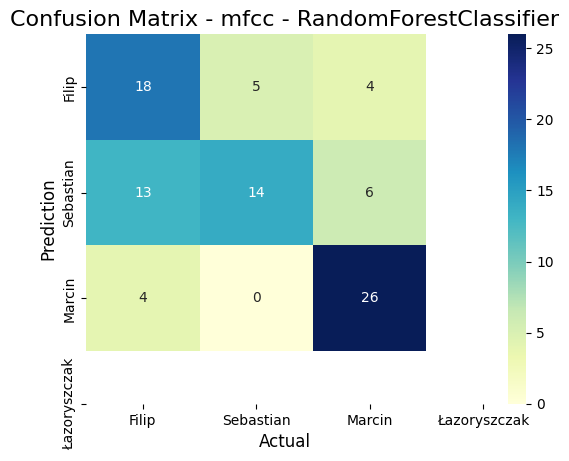

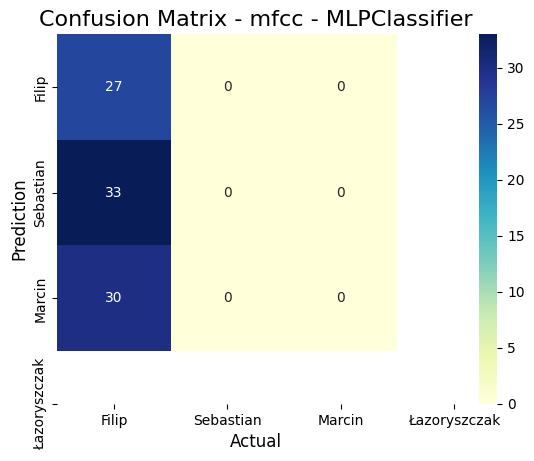

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.5222222222222223               precision    recall  f1-score   support

           A       0.41      0.48      0.44        27
           H       0.55      0.36      0.44        33
           N       0.61      0.73      0.67        30

    accuracy                           0.52        90
   macro avg       0.52      0.53      0.51        90
weighted avg       0.53      0.52      0.51        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.

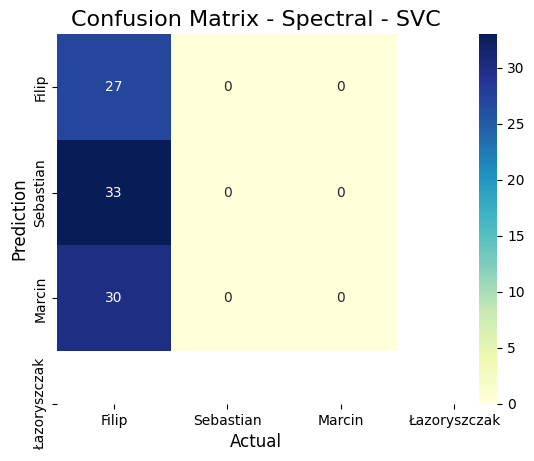

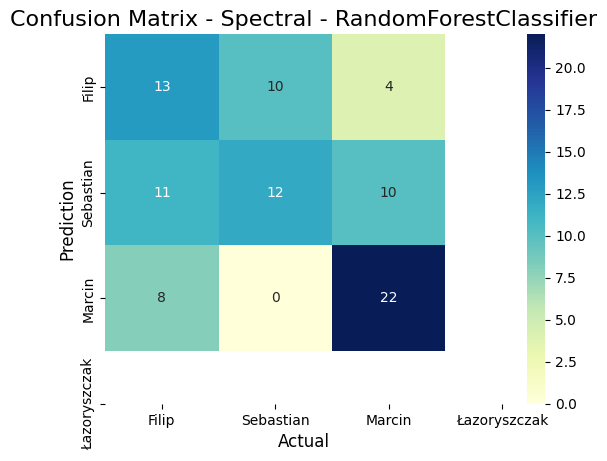

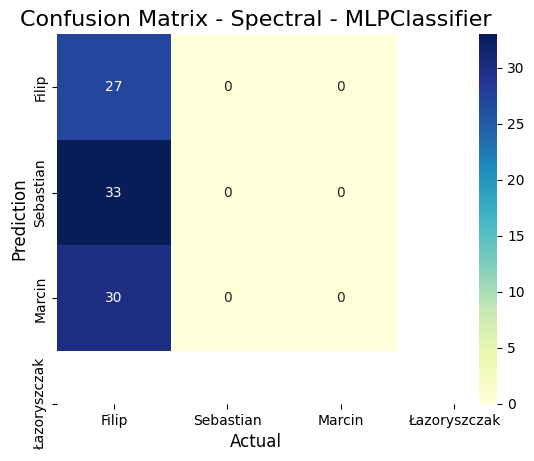

(180,)
0.36666666666666664               precision    recall  f1-score   support

           A       0.41      0.56      0.47        27
           H       0.00      0.00      0.00        33
           N       0.36      0.60      0.45        30

    accuracy                           0.37        90
   macro avg       0.26      0.39      0.31        90
weighted avg       0.24      0.37      0.29        90

0.3333333333333333               precision    recall  f1-score   support

           A       0.31      0.48      0.38        27
           H       0.32      0.18      0.23        33
           N       0.38      0.37      0.37        30

    accuracy                           0.33        90
   macro avg       0.33      0.34      0.33        90
weighted avg       0.34      0.33      0.32        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00  

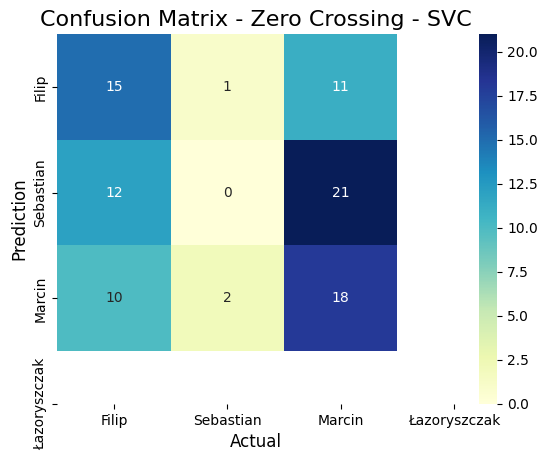

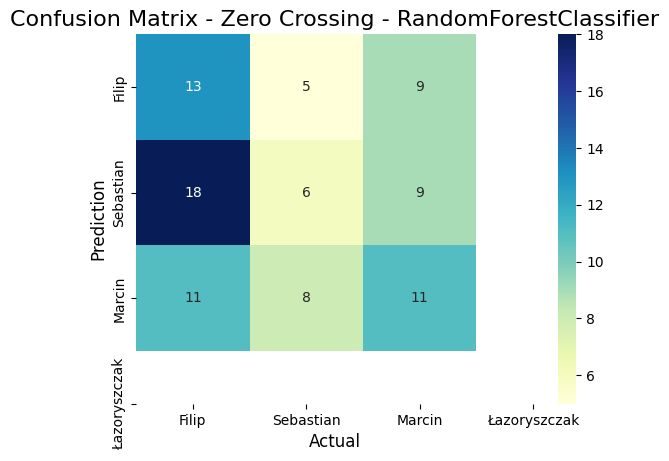

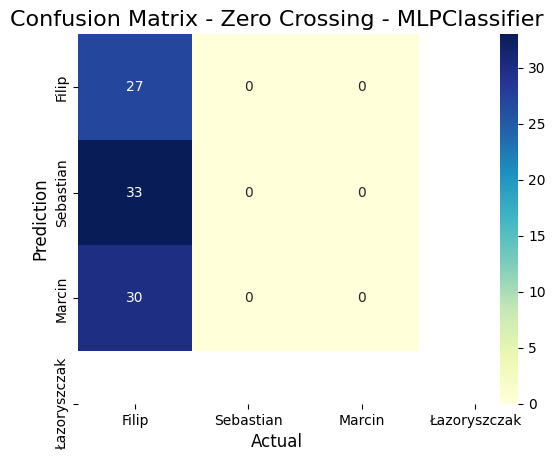

(180,)
0.5333333333333333               precision    recall  f1-score   support

           A       0.38      0.67      0.49        27
           H       0.75      0.09      0.16        33
           N       0.69      0.90      0.78        30

    accuracy                           0.53        90
   macro avg       0.61      0.55      0.48        90
weighted avg       0.62      0.53      0.47        90

0.7               precision    recall  f1-score   support

           A       0.55      0.78      0.65        27
           H       0.74      0.42      0.54        33
           N       0.85      0.93      0.89        30

    accuracy                           0.70        90
   macro avg       0.71      0.71      0.69        90
weighted avg       0.72      0.70      0.69        90

0.6111111111111112               precision    recall  f1-score   support

           A       0.50      0.67      0.57        27
           H       0.55      0.36      0.44        33
           N       0.78   

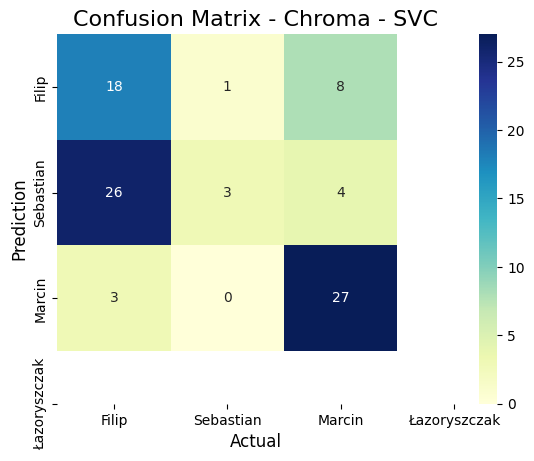

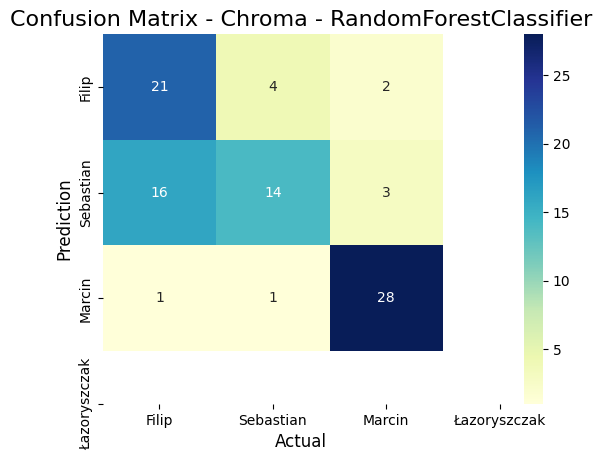

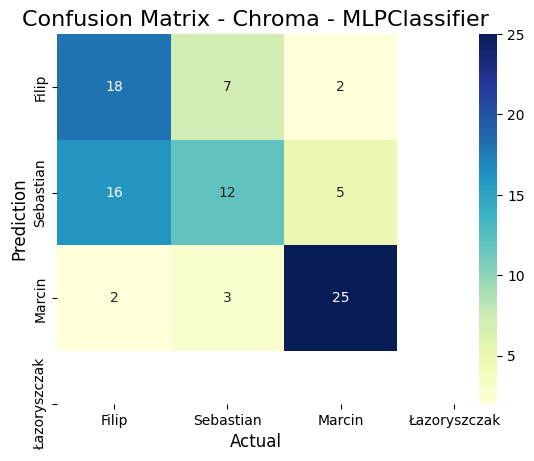

In [53]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 60%

In [54]:
noise_level = "N60"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_sentences, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_sentences, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_sentences, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_sentences, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_sentences)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.7555555555555555               precision    recall  f1-score   support

           A       0.67      0.81      0.73        27
           H       0.85      0.52      0.64        33
           N       0.78      0.97      0.87        30

    accuracy                           0.76        90
   macro avg       0.77      0.77      0.75        90
weighted avg       0.77      0.76      0.74        90

0.6333333333333333               precision    recall  f1-score   support

           A       0.51      0.70      0.59        27
           H       0.71      0.30      0.43        33
           N       0.72   

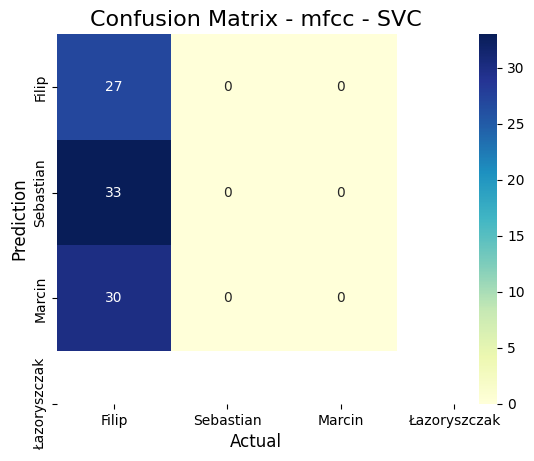

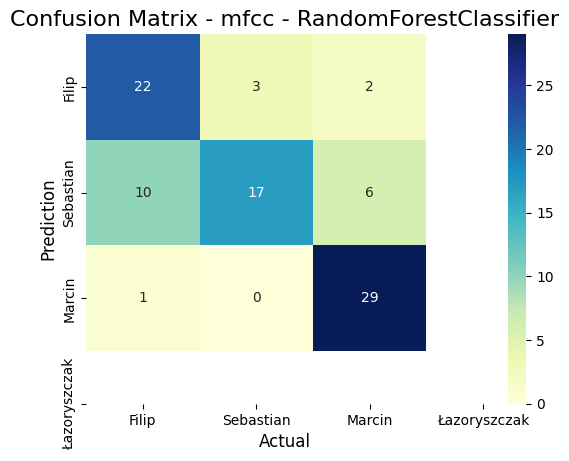

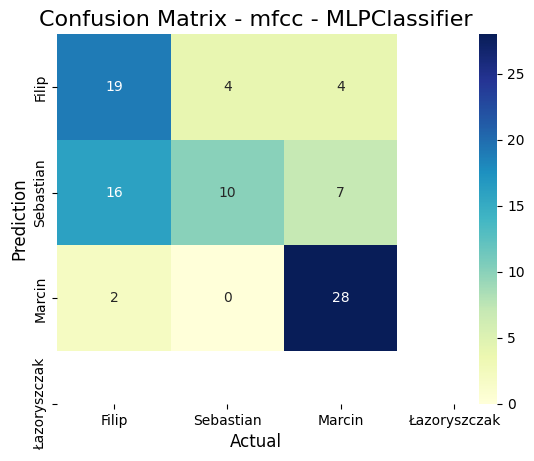

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.4777777777777778               precision    recall  f1-score   support

           A       0.29      0.26      0.27        27
           H       0.39      0.33      0.36        33
           N       0.66      0.83      0.74        30

    accuracy                           0.48        90
   macro avg       0.45      0.48      0.46        90
weighted avg       0.45      0.48      0.46        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.

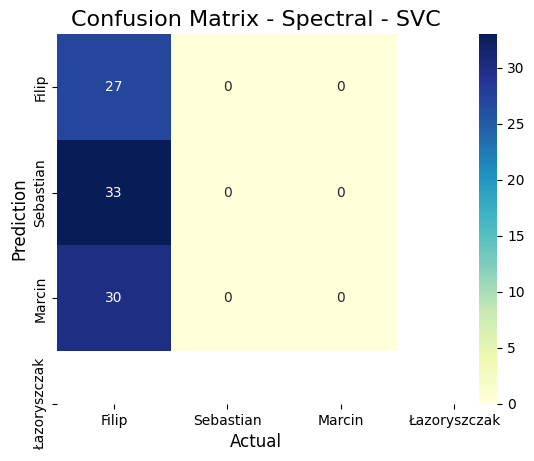

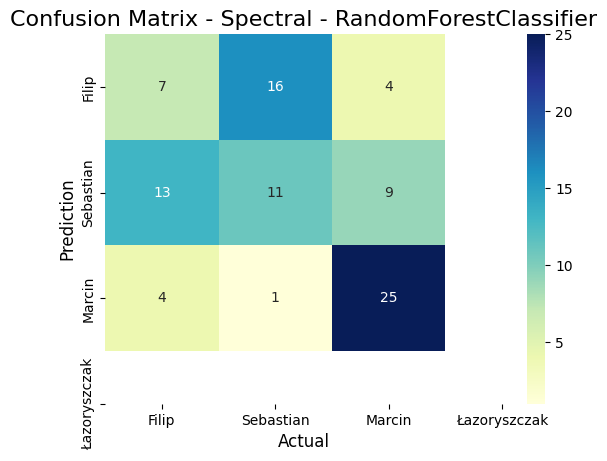

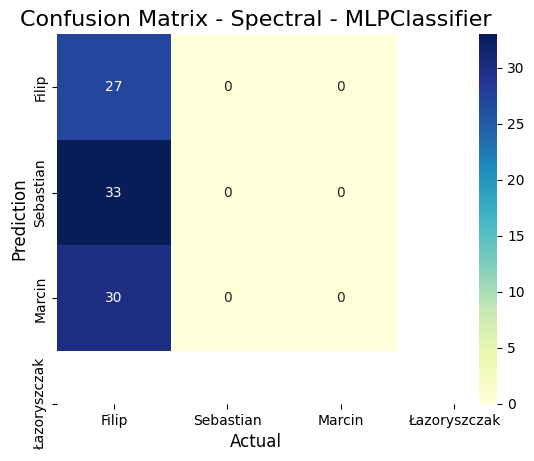

(180,)
0.36666666666666664               precision    recall  f1-score   support

           A       0.36      0.44      0.40        27
           H       0.25      0.03      0.05        33
           N       0.38      0.67      0.48        30

    accuracy                           0.37        90
   macro avg       0.33      0.38      0.31        90
weighted avg       0.33      0.37      0.30        90

0.3888888888888889               precision    recall  f1-score   support

           A       0.33      0.56      0.41        27
           H       0.41      0.21      0.28        33
           N       0.48      0.43      0.46        30

    accuracy                           0.39        90
   macro avg       0.41      0.40      0.38        90
weighted avg       0.41      0.39      0.38        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00  

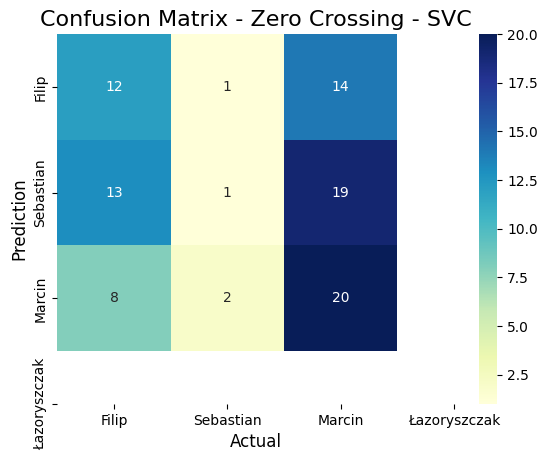

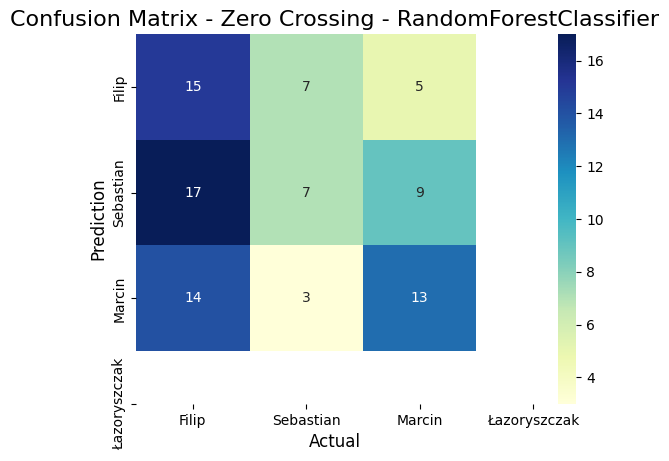

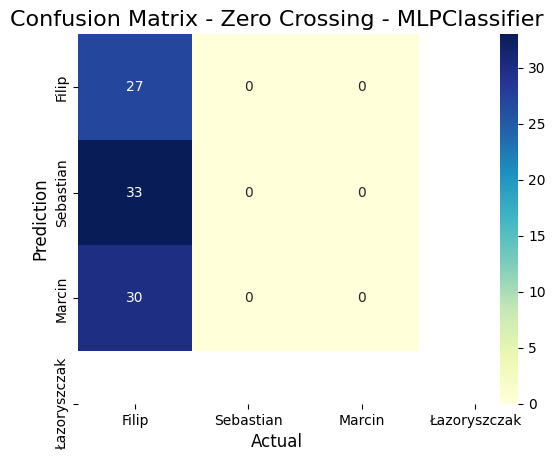

(180,)
0.4777777777777778               precision    recall  f1-score   support

           A       0.36      0.81      0.50        27
           H       1.00      0.03      0.06        33
           N       0.71      0.67      0.69        30

    accuracy                           0.48        90
   macro avg       0.69      0.50      0.42        90
weighted avg       0.71      0.48      0.40        90

0.6888888888888889               precision    recall  f1-score   support

           A       0.56      0.74      0.63        27
           H       0.82      0.42      0.56        33
           N       0.76      0.93      0.84        30

    accuracy                           0.69        90
   macro avg       0.71      0.70      0.68        90
weighted avg       0.72      0.69      0.67        90

0.6               precision    recall  f1-score   support

           A       0.50      0.74      0.60        27
           H       0.53      0.27      0.36        33
           N       0.76   

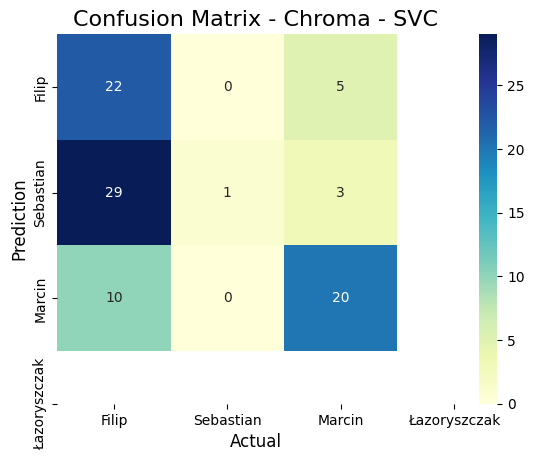

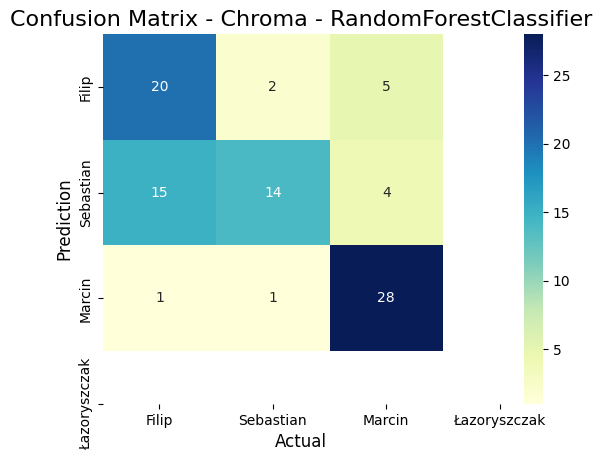

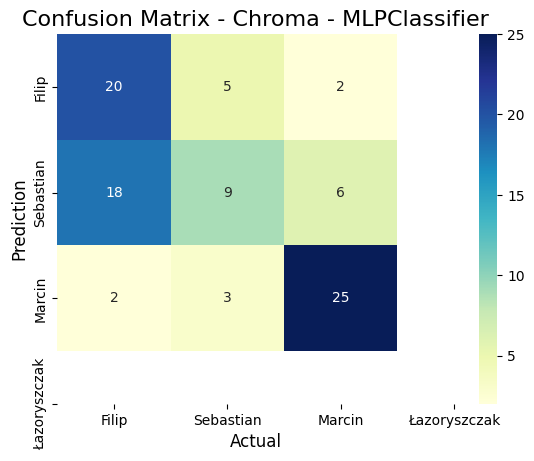

In [55]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 70%

In [56]:
noise_level = "N70"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_sentences, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_sentences, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_sentences, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_sentences, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_sentences)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.6777777777777778               precision    recall  f1-score   support

           A       0.55      0.78      0.65        27
           H       0.69      0.33      0.45        33
           N       0.81      0.97      0.88        30

    accuracy                           0.68        90
   macro avg       0.68      0.69      0.66        90
weighted avg       0.69      0.68      0.65        90

0.6222222222222222               precision    recall  f1-score   support

           A       0.56      0.70      0.62        27
           H       0.69      0.27      0.39        33
           N       0.65   

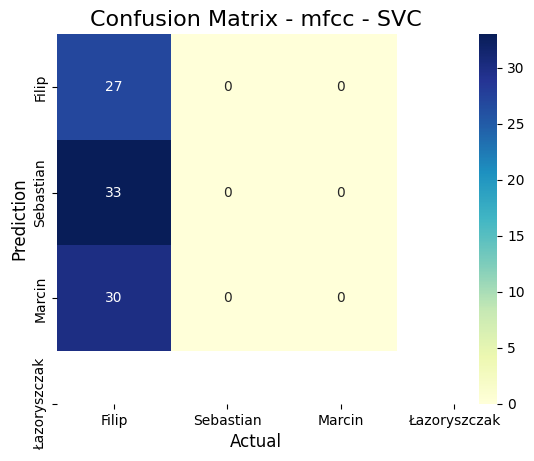

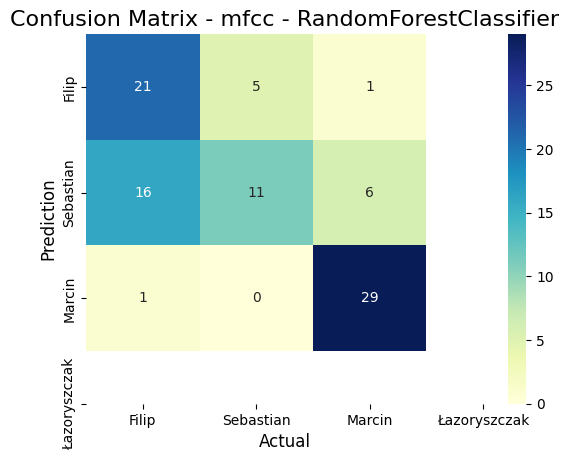

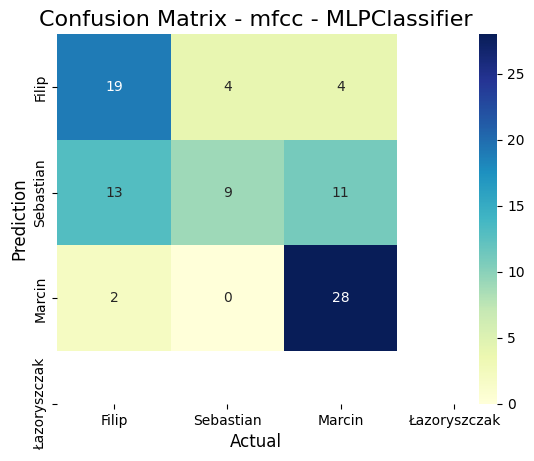

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.5444444444444444               precision    recall  f1-score   support

           A       0.39      0.44      0.41        27
           H       0.59      0.52      0.55        33
           N       0.67      0.67      0.67        30

    accuracy                           0.54        90
   macro avg       0.55      0.54      0.54        90
weighted avg       0.55      0.54      0.55        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.

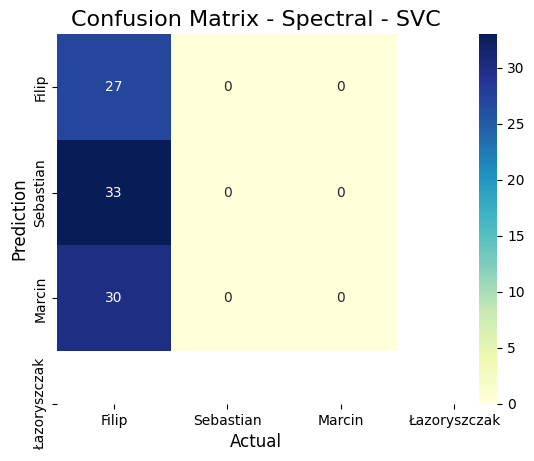

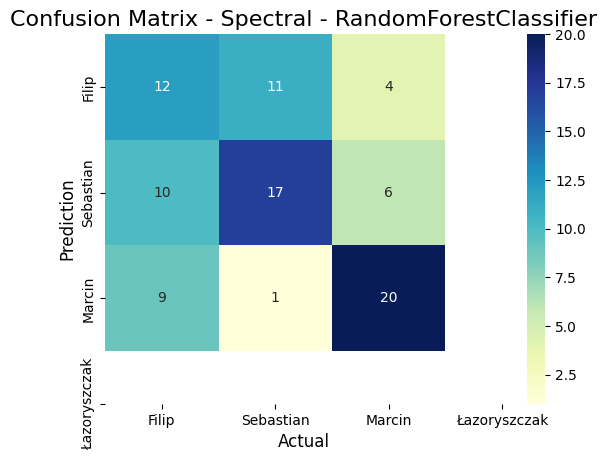

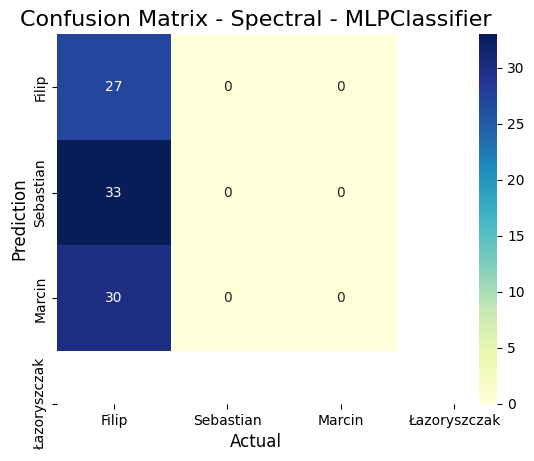

(180,)
0.37777777777777777               precision    recall  f1-score   support

           A       0.35      0.44      0.39        27
           H       0.20      0.03      0.05        33
           N       0.41      0.70      0.52        30

    accuracy                           0.38        90
   macro avg       0.32      0.39      0.32        90
weighted avg       0.32      0.38      0.31        90

0.35555555555555557               precision    recall  f1-score   support

           A       0.33      0.48      0.39        27
           H       0.44      0.33      0.38        33
           N       0.31      0.27      0.29        30

    accuracy                           0.36        90
   macro avg       0.36      0.36      0.35        90
weighted avg       0.36      0.36      0.35        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00 

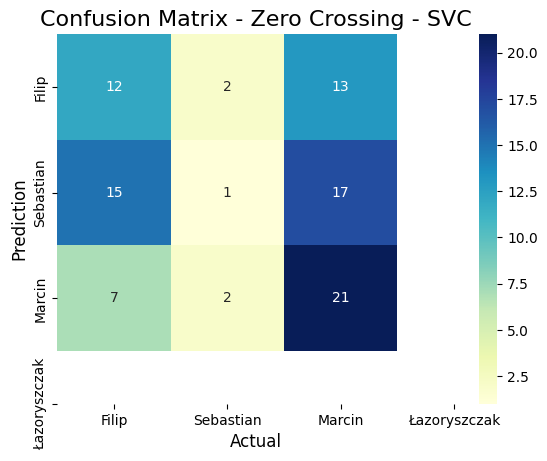

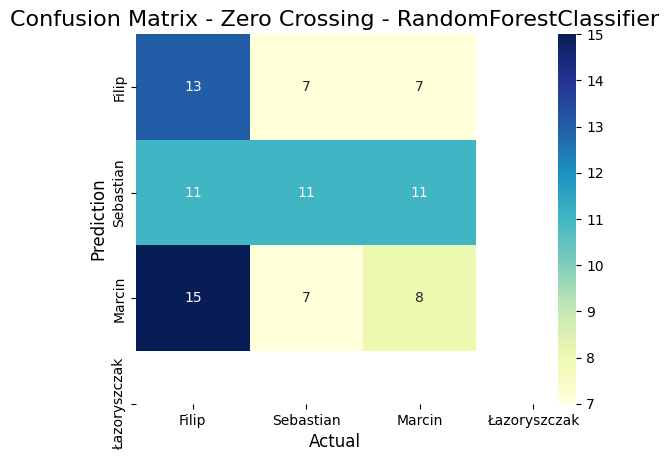

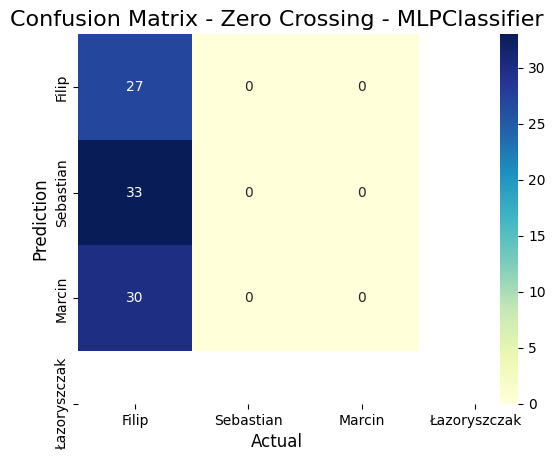

(180,)
0.3333333333333333               precision    recall  f1-score   support

           A       0.31      0.96      0.47        27
           H       0.00      0.00      0.00        33
           N       0.57      0.13      0.22        30

    accuracy                           0.33        90
   macro avg       0.29      0.37      0.23        90
weighted avg       0.28      0.33      0.21        90

0.5888888888888889               precision    recall  f1-score   support

           A       0.47      0.74      0.57        27
           H       0.65      0.33      0.44        33
           N       0.73      0.73      0.73        30

    accuracy                           0.59        90
   macro avg       0.62      0.60      0.58        90
weighted avg       0.62      0.59      0.58        90

0.5111111111111111               precision    recall  f1-score   support

           A       0.39      0.56      0.46        27
           H       0.50      0.33      0.40        33
           

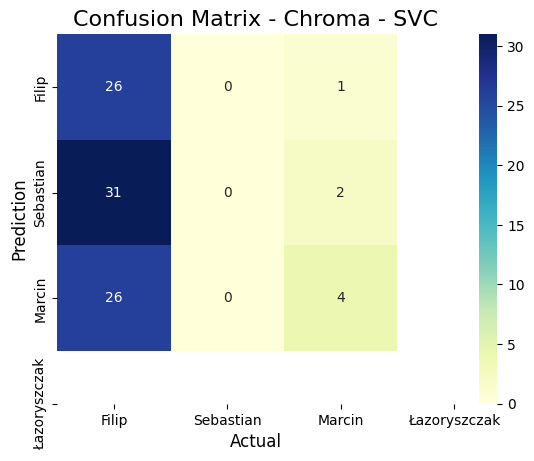

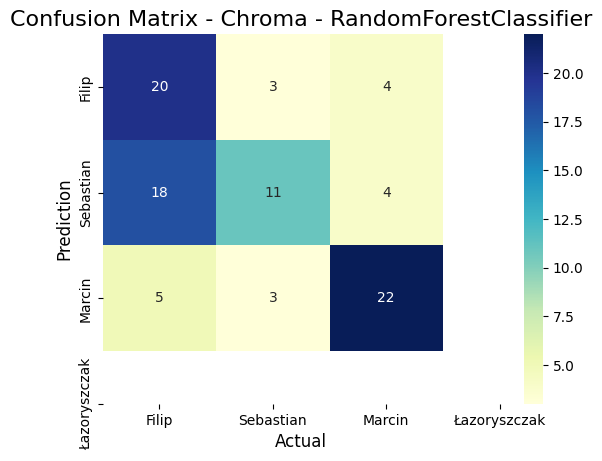

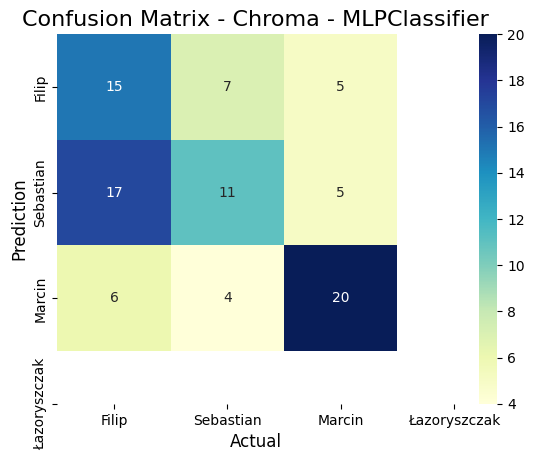

In [57]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Nosie - 80 %

In [58]:
noise_level = "N80"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_sentences, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_sentences, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_sentences, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_sentences, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_sentences)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.6777777777777778               precision    recall  f1-score   support

           A       0.59      0.63      0.61        27
           H       0.65      0.45      0.54        33
           N       0.76      0.97      0.85        30

    accuracy                           0.68        90
   macro avg       0.67      0.68      0.67        90
weighted avg       0.67      0.68      0.66        90

0.3333333333333333               precision    recall  f1-score   support

           A       0.32      0.26      0.29        27
           H       0.00      0.00      0.00        33
           N       0.34   

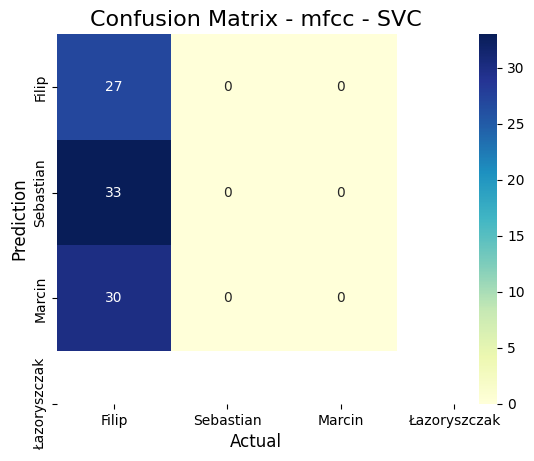

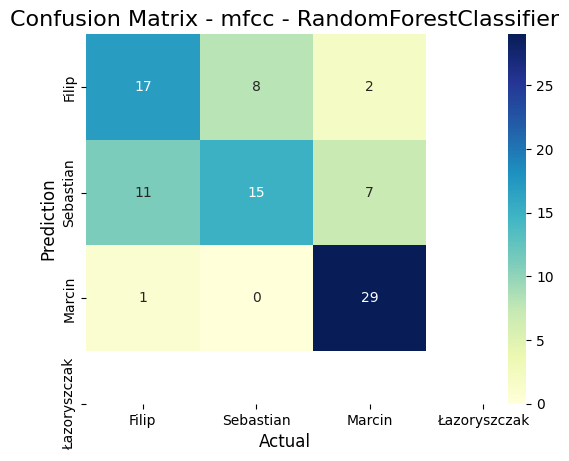

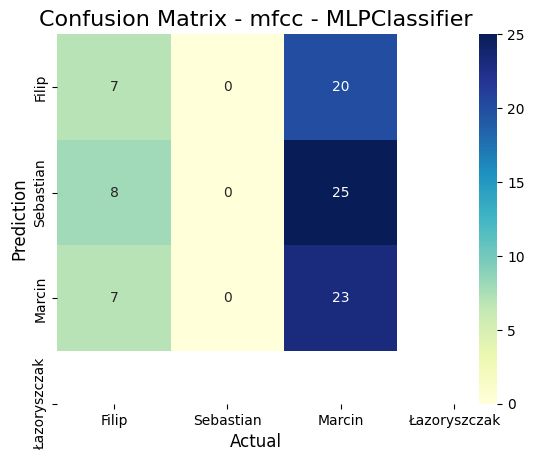

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.5333333333333333               precision    recall  f1-score   support

           A       0.41      0.56      0.47        27
           H       0.55      0.33      0.42        33
           N       0.67      0.73      0.70        30

    accuracy                           0.53        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.55      0.53      0.53        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.

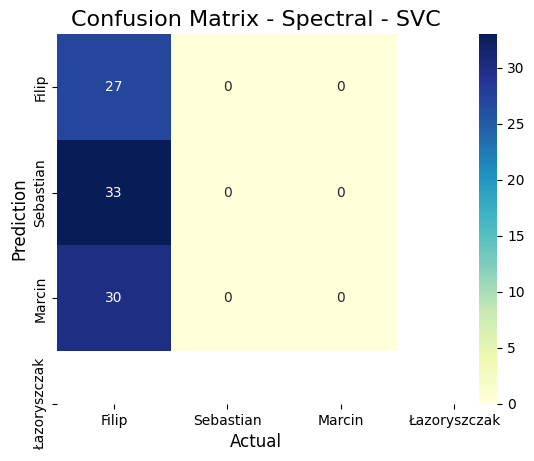

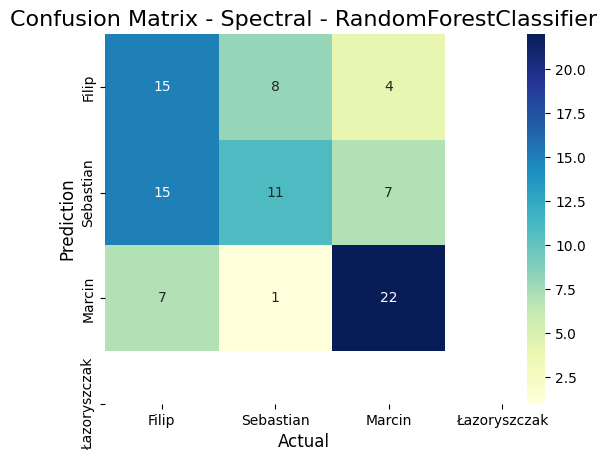

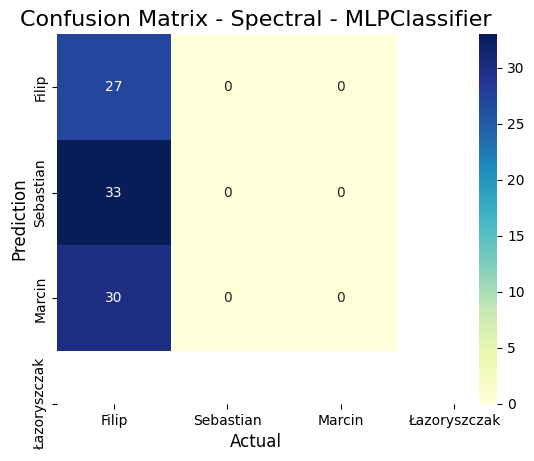

(180,)
0.35555555555555557               precision    recall  f1-score   support

           A       0.34      0.56      0.42        27
           H       0.17      0.03      0.05        33
           N       0.40      0.53      0.46        30

    accuracy                           0.36        90
   macro avg       0.30      0.37      0.31        90
weighted avg       0.30      0.36      0.30        90

0.2777777777777778               precision    recall  f1-score   support

           A       0.24      0.37      0.29        27
           H       0.15      0.09      0.11        33
           N       0.41      0.40      0.41        30

    accuracy                           0.28        90
   macro avg       0.27      0.29      0.27        90
weighted avg       0.27      0.28      0.27        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00  

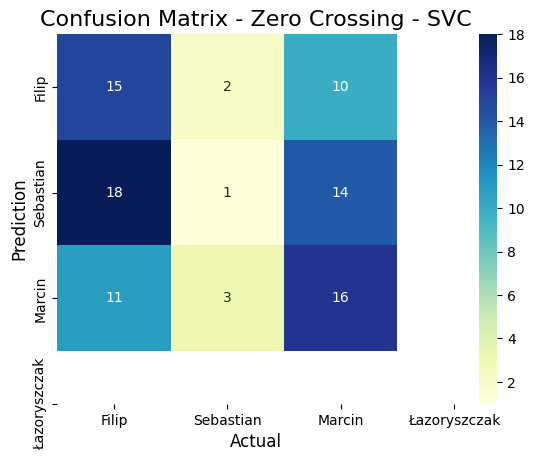

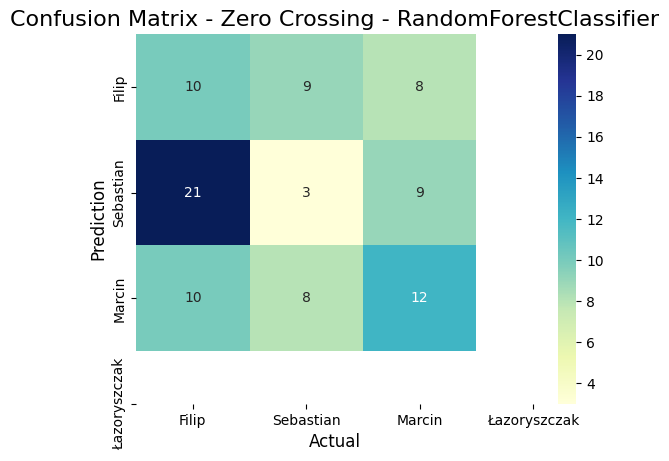

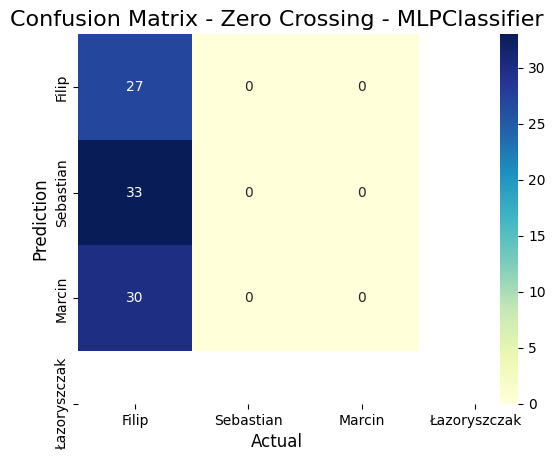

(180,)
0.35555555555555557               precision    recall  f1-score   support

           A       0.32      0.89      0.48        27
           H       0.00      0.00      0.00        33
           N       0.50      0.27      0.35        30

    accuracy                           0.36        90
   macro avg       0.27      0.39      0.27        90
weighted avg       0.26      0.36      0.26        90

0.4777777777777778               precision    recall  f1-score   support

           A       0.39      0.56      0.46        27
           H       0.61      0.33      0.43        33
           N       0.50      0.57      0.53        30

    accuracy                           0.48        90
   macro avg       0.50      0.49      0.47        90
weighted avg       0.51      0.48      0.47        90

0.4222222222222222               precision    recall  f1-score   support

           A       0.32      0.30      0.31        27
           H       0.44      0.33      0.38        33
          

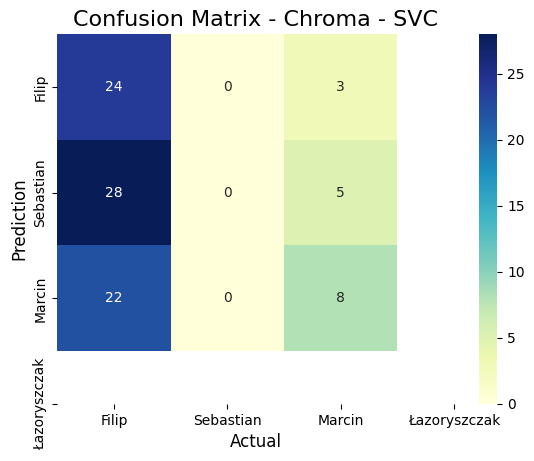

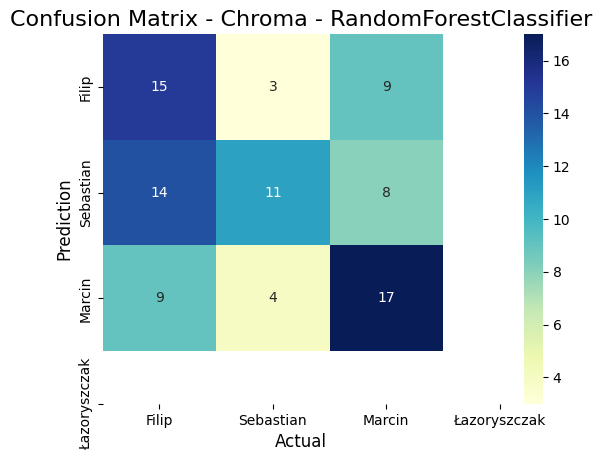

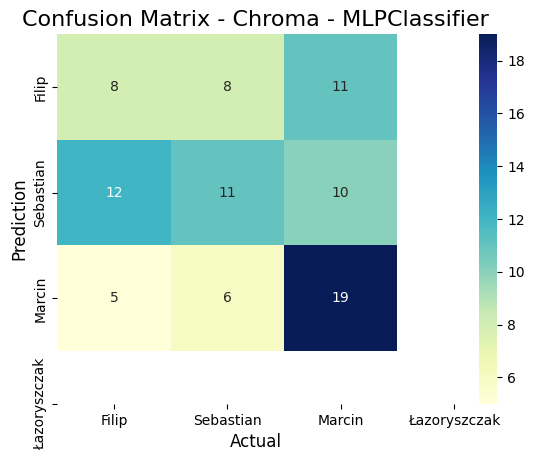

In [59]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 90 %

In [60]:
noise_level = "N90"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_sentences, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_sentences, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_sentences, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_sentences, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_sentences, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_sentences)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.6333333333333333               precision    recall  f1-score   support

           A       0.54      0.56      0.55        27
           H       0.59      0.48      0.53        33
           N       0.74      0.87      0.80        30

    accuracy                           0.63        90
   macro avg       0.62      0.64      0.63        90
weighted avg       0.63      0.63      0.63        90

0.5555555555555556               precision    recall  f1-score   support

           A       0.43      0.70      0.54        27
           H       0.71      0.36      0.48        33
           N       0.66   

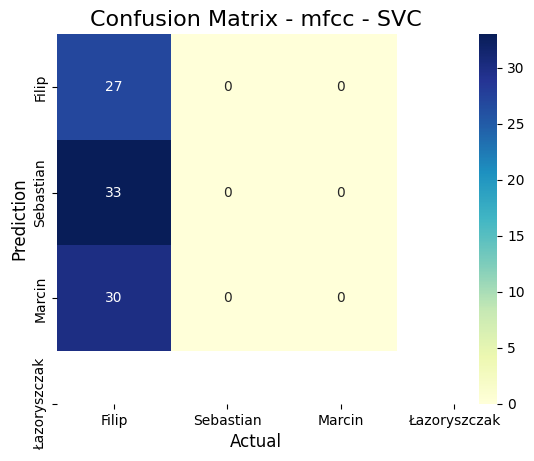

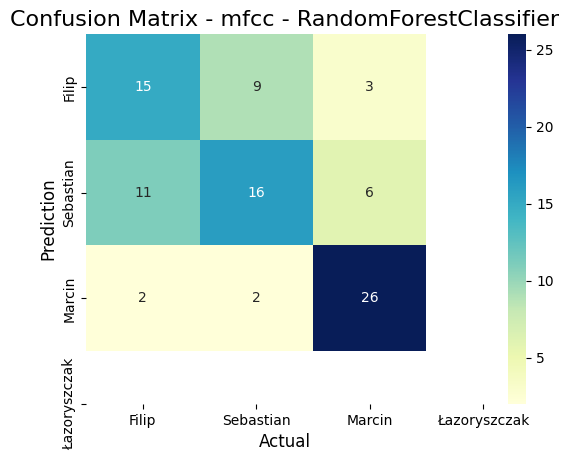

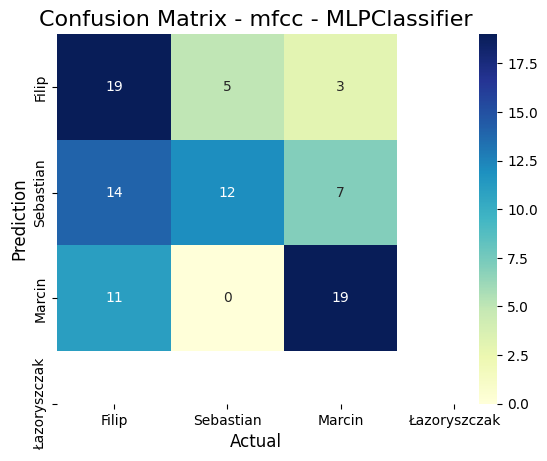

(180,)
0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0.00        30

    accuracy                           0.30        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.09      0.30      0.14        90

0.43333333333333335               precision    recall  f1-score   support

           A       0.33      0.52      0.41        27
           H       0.39      0.21      0.27        33
           N       0.60      0.60      0.60        30

    accuracy                           0.43        90
   macro avg       0.44      0.44      0.43        90
weighted avg       0.44      0.43      0.42        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00      0.00      0

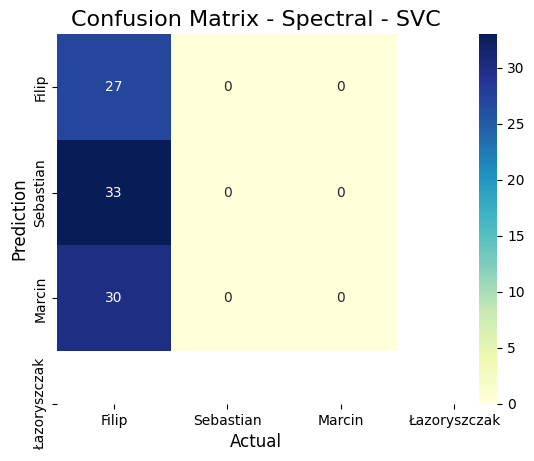

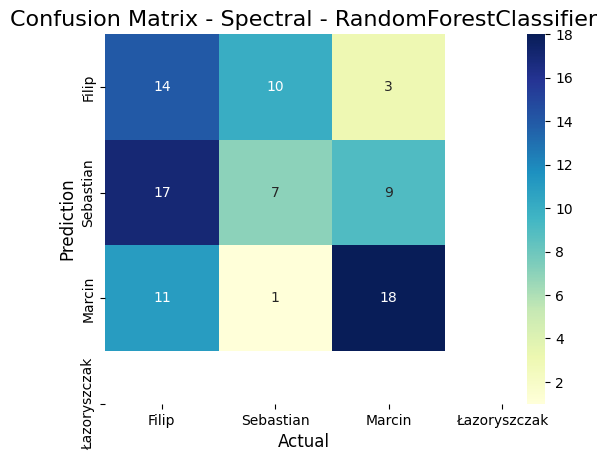

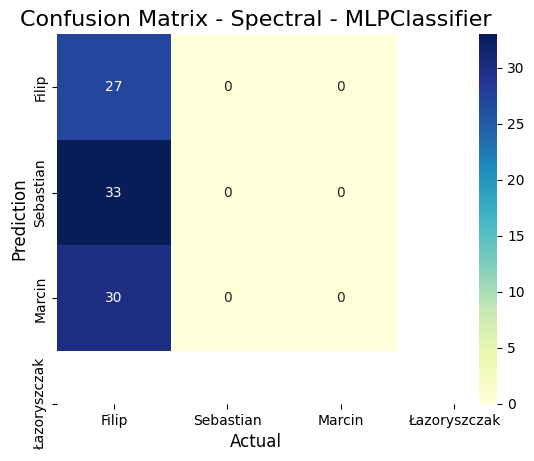

(180,)
0.34444444444444444               precision    recall  f1-score   support

           A       0.33      0.52      0.41        27
           H       0.17      0.03      0.05        33
           N       0.38      0.53      0.44        30

    accuracy                           0.34        90
   macro avg       0.29      0.36      0.30        90
weighted avg       0.29      0.34      0.29        90

0.34444444444444444               precision    recall  f1-score   support

           A       0.32      0.56      0.41        27
           H       0.29      0.12      0.17        33
           N       0.41      0.40      0.41        30

    accuracy                           0.34        90
   macro avg       0.34      0.36      0.33        90
weighted avg       0.34      0.34      0.32        90

0.3               precision    recall  f1-score   support

           A       0.30      1.00      0.46        27
           H       0.00      0.00      0.00        33
           N       0.00 

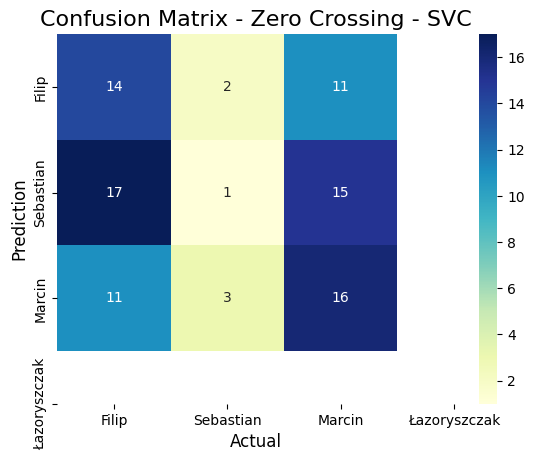

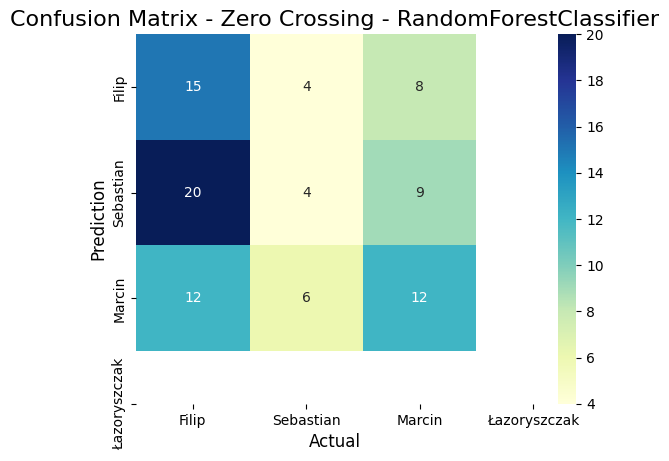

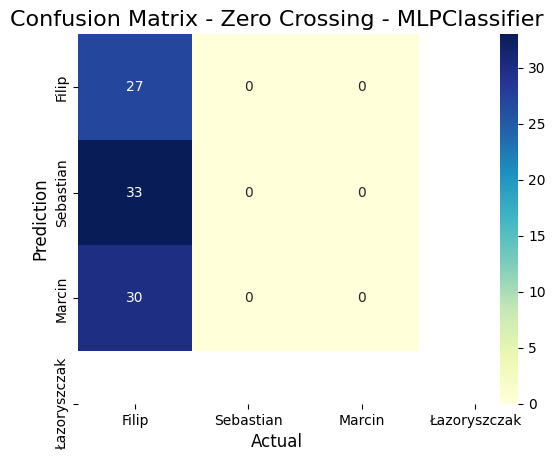

(180,)
0.32222222222222224               precision    recall  f1-score   support

           A       0.33      0.96      0.49        27
           H       0.00      0.00      0.00        33
           N       0.30      0.10      0.15        30

    accuracy                           0.32        90
   macro avg       0.21      0.35      0.21        90
weighted avg       0.20      0.32      0.20        90

0.4222222222222222               precision    recall  f1-score   support

           A       0.38      0.41      0.39        27
           H       0.42      0.30      0.35        33
           N       0.46      0.57      0.51        30

    accuracy                           0.42        90
   macro avg       0.42      0.43      0.42        90
weighted avg       0.42      0.42      0.42        90

0.3888888888888889               precision    recall  f1-score   support

           A       0.39      0.26      0.31        27
           H       0.36      0.39      0.38        33
          

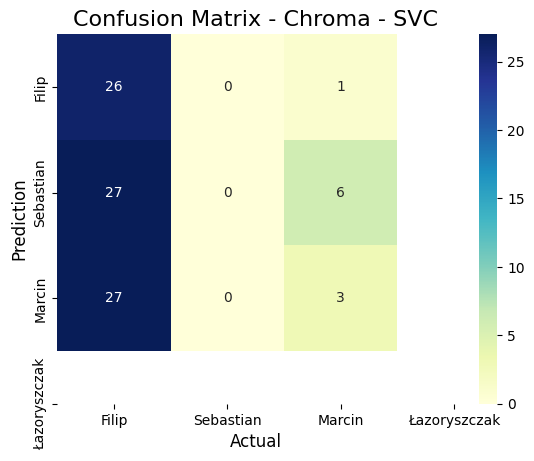

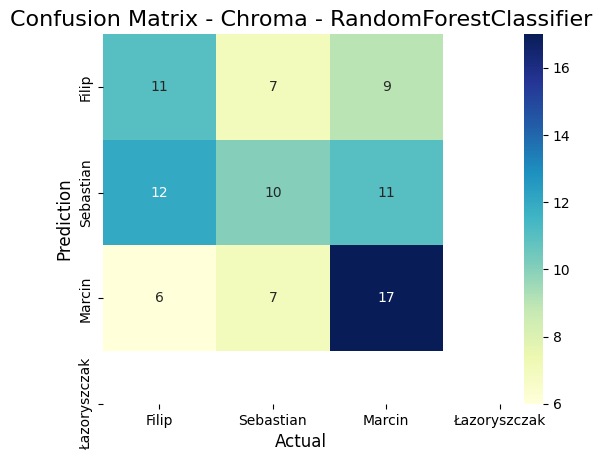

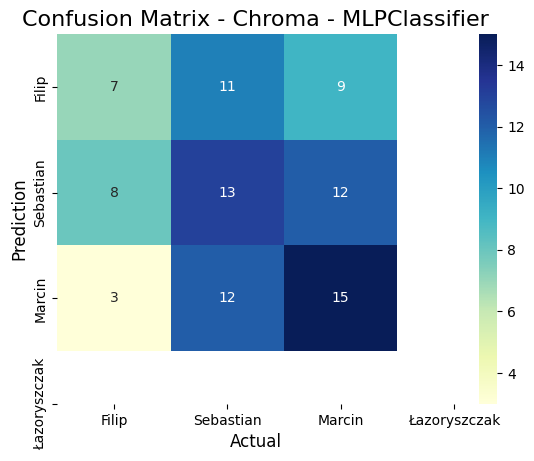

In [61]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")